# Libraries

In [324]:

# Data wrangling
from matplotlib.pylab import f
import pandas as pd
import numpy as np
import random

# Data visualisation
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.inspection import PartialDependenceDisplay

# My functions
import sys
sys.path.insert(0, "../../src")
from run_mp import *
from nfi_wrangling import *

# Other
from os import error
import datetime
from io import StringIO
import re
import warnings

# Global Settings

In [325]:
# NFI file name
nfi_file_name = "20231201-103649_nfi_dataset_for_analysis copy.csv"

# Folder prefix
folder_suffix = ""  # None for no prefix

user_input = {
    # Data selection
    "target": "mort_ba_yr_v1",  # Target variable
    "add_gee_data": True,  # If True, add GEE data
    "test_train_strata": [
        # "gre",
        "campagne_1",
        "top1_species_nfi",
    ],  # Strata for test/train splitting
    "na_drop_threshold": 0.1,  # If more than this proportion of NA values, drop the column
    # RF Definition
    "seed_nr": 42,  # Seed number for reproducibility
    "test_split": 0.2,  # Test/train splitting
    "weight_method": "inverse",  # Weighting method for RF samples
    # RF Tuning
    "cv_folds": 5,  # Folds to use in cross-validation (in REFCV, in GridSearchCV, in )
    "do_random_search": False,  # If True, do random search
    "do_prescribed_search": False,  # If True, do prescribed search
    "do_ref": False,  # If True, do REF
}

# Data Wrangling
rerun_calculation_growth_mortality = False
run_reports_major = True
run_reports_minor = False

In [326]:
# GREY = KEEP
# GREEN = REMOVED
# If not specified otherwise in google sheet or in routine

user_input_variable_removal = [
    # ! Variables with temporal information
    # "campagne_1",
    "campagne_2",
    "visite_1",
    "visite_2",
    "census_interval",
    # ! Variables with spatial information
    "ser",
    "gre",
    "dep",
    "lat",
    "lon",
    "lat_fr",
    "lon_fr",
    # ! Variables from NFI derivatives that hold ba information
    # "site_ba_prc_cut_at_v2",
    # "site_ba_prc_dead_at_v1",
    "site_ba_prc_dead_at_v2",
    "site_ba_prc_rec_at_v2",
    "site_total_ba_at_v1",
    "site_total_ba_at_v2",
    "ntrees_1",
    "ntrees_2",
    # ! Variables from calculation_growth_mortality:
    # * General variables / stand descriptions
    "idp",
    "n_plots",
    "n_ini",
    "n_sur",
    "n_fin",
    "n_rec",
    "n_die",
    "ba_at_v1_of_alive_trees",
    "ba_at_v2_of_alive_trees",
    "ba_at_v1_of_survivors",
    "ba_at_v2_of_survivors",
    "ba_at_v1_of_dead",
    "ba_at_v2_of_dead",
    "ba_at_v2_of_recruits",
    # * Growth and Mortality variables
    "mort_stems_prc_yr_esq",
    "mort_stems_prc_yr_hoshino",
    "rec_stems_prc_yr_hoshino",
    "mort_ba_prc_yr_hoshino",
    "tot_growth_ba_prc_yr_hoshino",
    "sur_growth_ba_prc_yr_hoshino",
    "tot_growth_ba_yr",
    "sur_growth_ba_yr",
    "mort_ba_yr_v1",
    "mort_ba_yr_v2",
    "tot_growth_ba_prc_yr",
    "sur_growth_ba_prc_yr",
    "mort_ba_prc_yr_v1",  # <--- Target variable
    "mort_ba_prc_yr_v2",
]

In [327]:
# TODO: Needs to be cleaned up
# Random Forest
add_gee_data = user_input["add_gee_data"]
target = user_input["target"]
na_drop_threshold = user_input["na_drop_threshold"]
seed_nr = user_input["seed_nr"]
test_split = user_input["test_split"]
test_train_strata = user_input["test_train_strata"]

# 📜 Functions

In [328]:
def create_new_run_folder(folder_suffix=None):
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Create the subdirectory in "model_runs" with today's date as the name
    subdirectory = os.path.join("model_runs", today)
    os.makedirs(subdirectory, exist_ok=True)

    # Set folder pattern in daily folder
    folder_pattern = "run_"

    # Filter subdirectory to regex match the folder_pattern (omits other files and folders)
    all_folders = [
        folder
        for folder in os.listdir(subdirectory)
        if re.match(folder_pattern, folder)
    ]

    # Count the number of folders in the subdirectory
    num_folders = len(all_folders)

    # print(num_folders, all_folders)

    # Create a new folder with the name "run_n" where n is the number of folders + 1
    if num_folders < 9:
        folder_nr = f"0{num_folders + 1}"
    else:
        folder_nr = num_folders + 1

    new_folder = os.path.join(subdirectory, f"{folder_pattern}{folder_nr}")

    if folder_suffix:
        new_folder += f"_{folder_suffix}"

    os.makedirs(new_folder)

    return new_folder

In [329]:
def get_current_folder():
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Create the subdirectory in "model_runs" with today's date as the name
    subdirectory = os.path.join("model_runs", today)

    # Set folder pattern in daily folder
    folder_pattern = "run_"

    # Filter subdirectory to regex match the folder_pattern (omits other files and folders)
    all_folders = [
        folder
        for folder in os.listdir(subdirectory)
        if re.match(folder_pattern, folder)
    ]

    # Since folders are sorted by run number, the last in the list is the newest
    # print(sorted(all_folders))
    current_folder = sorted(all_folders)[-1]
    return current_folder

In [330]:
def plot_grid_search_results(grid):
    """
    Params:
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results["mean_test_score"]
    stds_test = results["std_test_score"]
    means_train = results["mean_train_score"]
    stds_train = results["std_train_score"]

    ## Getting indexes of values per hyper-parameter
    masks = []
    masks_names = list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results["param_" + p_k].data == p_v))

    params = grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1, len(params), sharex="none", sharey="all", figsize=(20, 5))
    fig.suptitle("Score per parameter")
    fig.text(0.04, 0.5, "MEAN SCORE", va="center", rotation="vertical")
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i + 1 :])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle="--", marker="o", label="test")
        ax[i].errorbar(x, y_2, e_2, linestyle="-", marker="^", label="train")
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    # return fig

In [331]:
def show_top_predictors(
    X_train,
    vars_to_ohe,
    rf_model,
    with_aggregation=False,
    n_predictors=20,
    verbose=True,
):
    # Plot the variable importance
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    df_featimp = pd.DataFrame(
        {
            "Feature": X_train.columns[indices],
            "Importance": importances[indices],
        }
    )

    if verbose:
        print("Original size of df_featimp: ", df_featimp.shape)

    if with_aggregation:
        # For features matching the string in vars_to_ohe_red, sum up their importances and set name to vars_to_ohe_red
        # Make sure aggregation procedure is saved to file for checking later on:

        if verbose:
            display("Aggregating variables...")

        rows_to_drop = []
        rows_to_append = []
        text_to_save = []
        agg_dict = {}

        # vars_to_ohe_red = [var for var in vars_to_ohe if var in X_train.columns]

        # for var in vars_to_ohe_red:
        #     n_vars = 0
        #     feat_sum = 0
        #     merged_vars = []
        #     for i in range(len(df_featimp)):
        #         if var in df_featimp.loc[i, "Feature"]:
        #             merged_vars.append(df_featimp.loc[i, "Feature"])
        #             feat_sum += df_featimp.loc[i, "Importance"]
        #             n_vars += 1
        #             rows_to_drop.append(i)

        for var in vars_to_ohe:
            n_vars = 0
            feat_sum = 0
            merged_vars = []
            pattern = r"^" + var + r"_.*"

            for i in range(len(df_featimp)):
                if re.match(pattern, df_featimp.loc[i, "Feature"]):
                    merged_vars.append(df_featimp.loc[i, "Feature"])
                    feat_sum += df_featimp.loc[i, "Importance"]
                    n_vars += 1
                    rows_to_drop.append(i)

            # Attach to rows_to_append
            rows_to_append.append({"Feature": var, "Importance": feat_sum})

            # Print aggregation information
            # print(f"Merged {n_vars} vars into {var} containing: {merged_vars}")

            # Save aggregation to a dictionary
            agg_dict[var] = merged_vars

            # Save information to file
            if verbose:
                text_to_save = text_to_save + [
                    f"Merged {n_vars} vars into {var} containing:\n {merged_vars} \n\n"
                ]

        # Drop the rows that were merged
        df_featimp = df_featimp.drop(rows_to_drop)
        df_featimp = pd.concat(
            [df_featimp, pd.DataFrame(rows_to_append)], ignore_index=True
        )
        df_featimp = df_featimp.sort_values(by="Importance", ascending=False)

        if verbose:
            print("df_featimp after merging: ", df_featimp.shape)

            # Write to file
            file_path = f"{current_dir}/vip_aggregation_of_ohe_into_their_originals.txt"
            with open(file_path, "w") as file:
                for item in text_to_save:
                    file.write(f"{item}\n\n")
    else:
        agg_dict = None

    top_n = df_featimp.head(n_predictors)

    if verbose:
        # Show top n predictors table
        display(top_n)

        # Plot the variable importance
        sns_plot = sns.barplot(x="Importance", y="Feature", data=top_n, color="r")
        plt.tight_layout()

        # Save the barplot as an image file
        sns_plot.figure.savefig(
            f"{current_dir}/vip_plot_aggregated-{with_aggregation}.png"
        )

        # Save the dataframe as a tab-separated file
        df_featimp.to_csv(f"{current_dir}/vip_table_aggregated-{with_aggregation}.csv")

    # Return aggregation dictionary if needed
    return df_featimp, agg_dict

In [425]:
def assessing_top_predictors(
    rf_in,
    ignore_these,
    X_train_in,
    dict_ohe_in,
    with_aggregation=False,
    n_predictors=20,
    verbose=True,
):
    # Update n_predictors based on number of variables in X_train_in
    n_predictors = min(n_predictors, len(X_train_in.columns))

    # Get importances
    importances = rf_in.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_in.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    df_featimp_org = pd.DataFrame(
        {
            "Feature": X_train_in.columns[indices],
            "Importance": importances[indices],
            "Std": std[indices],
        }
    )

    df_featimp_agg = pd.DataFrame(
        {
            "Feature": [],
            "Importance": [],
            "Std": [],
        }
    )

    # Ugly quick fix but works...
    if not with_aggregation:
        reduced_var_ohe_dict = dict_ohe_in

    if with_aggregation:
        # Reduce dictionary to hold only keys for which there is a value that matches the inputed X_train_in
        reduced_var_ohe_dict = {
            key: value
            for key, value in dict_ohe_in.items()
            if any(col in X_train_in.columns for col in value)
        }

        # Remove variables to ignore from dictionary
        for var in ignore_these:
            if var in reduced_var_ohe_dict.keys():
                del reduced_var_ohe_dict[var]

        # Loop through all keys in the dictionary
        for key in reduced_var_ohe_dict.keys():
            importances_per_key = []
            stdevs_per_key = []

            # Loop through all variables in the key
            for var in reduced_var_ohe_dict[key]:
                # Loop through all variables in the original featimp df
                for i in range(len(df_featimp_org)):
                    # Check if the row in the featimp corresponds to value of the key
                    # If so, gather all variables for that key and aggregate them.
                    if df_featimp_org["Feature"].iloc[i] == var:
                        importances_per_key.append(df_featimp_org["Importance"].iloc[i])
                        stdevs_per_key.append(df_featimp_org["Importance"].iloc[i])

                n_vars_per_key = len(reduced_var_ohe_dict[key])
                if n_vars_per_key > 1:
                    importance = np.sum(importances_per_key)
                    stdev = sum([x**2 for x in stdevs_per_key])
                else:
                    importance = importances_per_key[0]
                    stdev = stdevs_per_key[0]

            new_row = pd.DataFrame(
                {
                    "Feature": [key],
                    "Importance": [importance],
                    "Std": [stdev],
                    "Importance_per_key": [importances_per_key],
                    "Vars_per_key": [n_vars_per_key],
                    "Vars_in_key": [list(reduced_var_ohe_dict[key])],
                }
            )

            df_featimp_agg = pd.concat([df_featimp_agg, new_row], axis=0)
            df_featimp_final = df_featimp_agg.sort_values(
                by="Importance", ascending=False
            ).reset_index(drop=True)

    else:
        df_featimp_final = (
            df_featimp_org.copy()
            .sort_values(by="Importance", ascending=False)
            .reset_index(drop=True)
        )

    # --------------------------------------------------------
    if verbose:
        # Show top n predictors table
        top_n = df_featimp_final.head(n_predictors)
        if with_aggregation:
            my_title = f"Top {n_predictors} predictors with aggregation"
        else:
            my_title = f"Top {n_predictors} predictors without aggregation"

        # Plot the variable importance
        sns_plot = sns.barplot(x="Importance", y="Feature", data=top_n, color="r")
        sns_plot.set_title(my_title)
        plt.tight_layout()

        # Save the barplot as an image file
        # sns_plot.figure.savefig(
        #     f"{current_dir}/vip_plot_aggregated-{with_aggregation}.png"
        # )

        # Save the dataframe as a tab-separated file
        # df_featimp.to_csv(f"{current_dir}/vip_table_aggregated-{with_aggregation}.csv")

        print(
            f"assessing_top_predictors()...",
            f"\n - Number of columns in X_train_in is equal to number of rows in df_featimp_org: {len(X_train_in.columns) == df_featimp_org.shape[0]}",
            f"\n - Number of vars in training set is equal to number of rows in df_featimp_agg: {len(reduced_var_ohe_dict) == df_featimp_agg.shape[0]}",
            f"\n - Size of original df_featimp_org: {df_featimp_org.shape}",
            f"\n - Size of aggregated df_featimp_agg: {df_featimp_agg.shape}",
        )

    return df_featimp_final

In [333]:
def model_evaluation(rf_model, X_test, y_test):
    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Calculate the evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Print the evaluation metrics
    print("R2 score: ", r2)
    print("RMSE: ", rmse)
    print("MAE: ", mae)

    # Plot the predicted against true values using seaborn
    sns.regplot(
        x=y_test,
        y=y_pred,
        scatter_kws=dict(color="gray", s=10, alpha=0.8),
        line_kws=dict(color="blue"),
    )
    plt.plot(ls="--", c="red")
    plt.xlabel("Observations")
    plt.ylabel("Predictions")
    plt.title(
        f"Predicted versus observed values of {target}\nR2 score: {round(r2, 2)}, RMSE: {round(rmse, 2)}, MAE: {round(mae, 2)}"
    )

    # Set y and x axis limits based on the maximum value in y_pred or y_test
    max_value = max(max(y_pred), max(y_test))
    plt.ylim(0, max_value)
    plt.xlim(0, max_value)

    # Add a red dotted 1:1 line
    plt.plot([0, max_value], [0, max_value], ls="--", c="r")

    # Set equal scaling (i.e., 1:1 aspect ratio)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.savefig(f"{current_dir}/predicted_vs_observed.png")
    plt.show()

In [334]:
def model_evaluation_2(rf_model, X_train, y_train, X_test, y_test):
    # Predict on the train and test data
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    # Calculate the evaluation metrics for train data
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Calculate the evaluation metrics for test data
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Print the evaluation metrics for train data
    print("Train Data:")
    print(" - R2 score:\t ", round(r2_train, 2))
    print(" - RMSE:\t ", round(rmse_train, 2))
    print(" - MAE:\t\t ", round(mae_train, 2))

    # Print the evaluation metrics for test data
    print("\nTest Data:")
    print(" - R2 score:\t ", round(r2_test, 2))
    print(" - RMSE:\t ", round(rmse_test, 2))
    print(" - MAE:\t\t ", round(mae_test, 2))

    # Set the figure size
    plt.figure(figsize=(12, 6))

    # Plot the predicted versus observed values for train data
    plt.subplot(1, 2, 1)
    sns.regplot(
        x=y_train,
        y=y_train_pred,
        scatter_kws=dict(color="gray", s=10, alpha=0.8),
        line_kws=dict(color="blue"),
    )
    plt.plot(ls="--", c="red")
    plt.xlabel("Observations")
    plt.ylabel("Predictions")
    plt.title(f"Train Data (target: {y_test.name})")

    # Set y and x axis limits based on the maximum value in y_train_pred or y_train
    max_value_train = max(max(y_train_pred), max(y_train))
    plt.ylim(0, max_value_train)
    plt.xlim(0, max_value_train)

    # Add a red dotted 1:1 line
    plt.plot([0, max_value_train], [0, max_value_train], ls="--", c="r")

    # Set equal scaling (i.e., 1:1 aspect ratio)
    plt.gca().set_aspect("equal", adjustable="box")

    # Add metrics reporting to the top right corner
    plt.text(
        0.2,
        0.95,
        f"R2: {round(r2_train, 2)}\nRMSE: {round(rmse_train, 2)}\nMAE: {round(mae_train, 2)}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    # Plot the predicted versus observed values for test data
    plt.subplot(1, 2, 2)
    sns.regplot(
        x=y_test,
        y=y_test_pred,
        scatter_kws=dict(color="gray", s=10, alpha=0.8),
        line_kws=dict(color="blue"),
    )
    plt.plot(ls="--", c="red")
    plt.xlabel("Observations")
    plt.ylabel("Predictions")
    plt.title(f"Test Data (target: {y_train.name})")

    # Set y and x axis limits based on the maximum value in y_test_pred or y_test
    max_value_test = max(max(y_test_pred), max(y_test))
    plt.ylim(0, max_value_test)
    plt.xlim(0, max_value_test)

    # Add a red dotted 1:1 line
    plt.plot([0, max_value_test], [0, max_value_test], ls="--", c="r")

    # Set equal scaling (i.e., 1:1 aspect ratio)
    plt.gca().set_aspect("equal", adjustable="box")

    # Add metrics reporting to the top right corner
    plt.text(
        0.2,
        0.95,
        f"R2: {round(r2_test, 2)}\nRMSE: {round(rmse_test, 2)}\nMAE: {round(mae_test, 2)}",
        horizontalalignment="right",
        verticalalignment="top",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"),
    )

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figures
    plt.show()

In [335]:
def do_ohe(Xy, variables_not_to_ohe=[], verbose=True):
    ohe_these = []

    for var in Xy:
        if Xy[var].dtype == "O":
            ohe_these = ohe_these + [var]

    # Remove variables that should not be one-hot encoded
    ohe_these = [var for var in ohe_these if var not in variables_not_to_ohe]

    # One-hot encoding
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    df_ohe = pd.DataFrame(
        ohe.fit_transform(Xy[ohe_these]),
        columns=ohe.get_feature_names_out(ohe_these),
    )

    # Attach the non-encoded variables
    df_out = pd.concat(
        [
            Xy.drop(columns=ohe_these).reset_index(drop=True),
            df_ohe.reset_index(drop=True),
        ],
        axis=1,
    )

    # Verbose output
    if verbose:
        print(
            f"do_ohe():",
            f"\n - Shape before OHE:\t\t {Xy.shape}",
            f"\n - Shape after OHE:\t\t {df_out.shape}",
            f"\n - Change in Nr. of columns:\t {df_out.shape[1] - Xy.shape[1]} (dropped: {len(ohe_these)}, added: {df_ohe.shape[1]})",
            f"\n - Variables that were ohe:\t {' | '.join(sorted(ohe_these))}",
            f"\n - New variables:\t\t {' | '.join(sorted(df_ohe.columns.to_list()))}",
        )

    return df_out

In [336]:
def pp_this(
    vars_to_ohe,
    numerics_with_na,
    X_train,
    X_test,
    current_dir,
    verbose=True,
):
    print("FUNCTION DISABLED")

    # # Get numerical variables that have at least one NA value
    # numerics_with_na = [
    #     var for var in X_train.columns if (X_train[var].isnull().sum() > 0 and X_train[var].dtype != "O")
    # ]

    # # Reduce vars_to_ohe to only hold variables that are in the dataset
    # vars_to_ohe_red = [var for var in vars_to_ohe if var in X_train.columns]

    # # Save to file what variables have been ohe
    # file_path = f"{current_dir}/ohe_variables.txt"
    # with open(file_path, "w") as file:
    #     for item in vars_to_ohe_red:
    #         file.write(f"{item}\n")

    # # Initial variables
    # initial_vars = X_train.columns.to_list()

    # # Verbose
    # if verbose:
    #     print(f"Shape of X_train before pre-processing: {X_train.shape}")
    #     print(f"Shape of X_test before pre-processing: {X_test.shape}")

    # # One-hot encoding
    # ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    # X_train_encoded = pd.DataFrame(
    #     ohe.fit_transform(X_train[vars_to_ohe_red]),
    #     columns=ohe.get_feature_names_out(vars_to_ohe_red),
    # )

    # X_test_encoded = pd.DataFrame(
    #     ohe.transform(X_test[vars_to_ohe_red]),
    #     columns=ohe.get_feature_names_out(vars_to_ohe_red),
    # )

    # # Concatenate the encoded variables with the rest of the dataset
    # # A bit hacky because the index is reset, but it works
    # df1 = X_train.drop(vars_to_ohe_red, axis=1).reset_index(drop=True)
    # df2 = X_train_encoded.reset_index(drop=True)
    # X_train = pd.concat([df1, df2], axis=1)

    # df1 = X_test.drop(vars_to_ohe_red, axis=1).reset_index(drop=True)
    # df2 = X_test_encoded.reset_index(drop=True)
    # X_test = pd.concat([df1, df2], axis=1)

    # # KNN imputation
    # if len(numerics_with_na) > 0:
    #     imputer = KNNImputer(n_neighbors=5)
    #     X_train[numerics_with_na] = imputer.fit_transform(X_train[numerics_with_na])
    #     X_test[numerics_with_na] = imputer.transform(X_test[numerics_with_na])

    # # Final vars
    # final_vars = X_train.columns.to_list()

    # # Shape of train and text set
    # if verbose:
    #     print(f"\nShape of X_train after pre-processing: {X_train.shape}")
    #     print(f"Shape of X_test after pre-processing: {X_test.shape}")

    #     print(f"\nNewly added variables {len(final_vars) - len(initial_vars)}: ")
    #     [print(var, end=" | ") for var in final_vars if var not in initial_vars]

    #     # Write dataframe infos to text
    #     buffer = StringIO()
    #     X_train.info(buf=buffer, verbose=True)
    #     info_str = buffer.getvalue()
    #     file_path = f"{current_dir}/X_train_info_after_imputation.txt"
    #     with open(file_path, "w") as file:
    #         file.write(info_str)

    #     buffer = StringIO()
    #     X_test.info(buf=buffer, verbose=True)
    #     info_str = buffer.getvalue()
    #     file_path = f"{current_dir}/X_test_info_after_imputation.txt"
    #     with open(file_path, "w") as file:
    #         file.write(info_str)

    # # Return dataframes
    # return X_train, X_test

In [337]:
def impute_numerical_na(
    Xy_train_in,
    Xy_test_in,
    target_in,
    n_neighbours=10,
    vars_not_to_impute=[],
    verbose=True,
):
    # Define in and out dataframees
    Xy_train_in = Xy_train_in.copy().reset_index(drop=True)
    Xy_train_out = Xy_train_in.copy().reset_index(drop=True)

    Xy_test_in = Xy_test_in.copy().reset_index(drop=True)
    Xy_test_out = Xy_test_in.copy().reset_index(drop=True)

    # Get numerical variables with NAs
    all_numerics = Xy_train_in.columns[(Xy_train_in.dtypes != "O")].tolist()

    num_na_train = Xy_train_out.columns[
        (Xy_train_out.dtypes != "O") & (Xy_train_out.isna().any())
    ].tolist()
    num_na_test = Xy_test_out.columns[
        (Xy_test_out.dtypes != "O") & (Xy_test_out.isna().any())
    ].tolist()

    num_na_train = list(set(num_na_train + num_na_test))

    # Check if target had NA values and inform
    detected_vars = []
    for var in vars_not_to_impute:
        if var in num_na_train:
            detected_vars.append(var)
            num_na_train.remove(var)

    # Do imputation
    if len(num_na_train) > 0:
        imputer = KNNImputer(n_neighbors=n_neighbours)
        Xy_train_out[num_na_train] = imputer.fit_transform(Xy_train_out[num_na_train])
        Xy_test_out[num_na_train] = imputer.transform(Xy_test_out[num_na_train])

    if verbose:
        print(
            f"impute_numerical_na():",
            f"\n - Shape of Xy_train before imputation: {Xy_train_in.shape}",
            f"\n - Shape of Xy_train before imputation: {Xy_train_out.shape}",
            f"\n",
            f"\n - Shape of Xy_test before imputation: {Xy_test_in.shape}",
            f"\n - Shape of Xy_test before imputation: {Xy_test_out.shape}",
            f"\n",
            f"\n - Out of {len(all_numerics)}, {len(num_na_train)} had NA values and were imputed using KNN with {n_neighbours} neighbours.",
            f"\n - Imputed variables: {' | '.join(sorted(num_na_train))}",
        )

    if len(detected_vars) > 0:
        print(
            f"\n - ❌❌❌ Variables {detected_vars} had NA values but are not meant to be imputed! They were not imputed but their values should be fixed! ❌❌❌"
        )

    return Xy_train_out, Xy_test_out

In [338]:
def overlay_barplot(ax, df1, df1_name, df2, df2_name, variable, subtitle=None):
    # Number of levels in variable
    nvar = len(set([var for var in df1[variable]] + [var for var in df2[variable]]))

    # Calculate the relative frequencies for each level in df1
    df1_counts = df1[variable].value_counts(normalize=True).sort_values(ascending=False)
    df1_counts = df1_counts * 100

    # Calculate the relative frequencies for each level in df2
    df2_counts = df2[variable].value_counts(normalize=True).sort_values(ascending=False)
    df2_counts = df2_counts * 100

    # Combine the counts into a single dataframe
    df_counts = pd.concat([df1_counts, df2_counts], axis=1)
    df_counts.columns = [df1_name, df2_name]

    # Plotting the bar plot
    ax.barh(
        df_counts.index, df_counts[df1_name], align="center", label=df1_name, alpha=0.5
    )
    ax.barh(
        df_counts.index, df_counts[df2_name], align="center", label=df2_name, alpha=0.5
    )

    # Adding titles and labels
    ax.set_title("Overlaying Bar Plot of variable of total " + str(nvar) + " strata")
    ax.set_xlabel("Relative Frequency [%]")
    ax.set_ylabel("Level of variable")
    ax.legend()

    if subtitle is not None:
        ax.text(
            0.5,
            0.95,
            subtitle,
            transform=ax.transAxes,
            ha="center",
            va="center",
        )

In [339]:
def get_weights_from_y(y_in, method="squared"):
    if method == "none":
        return y_in
    if method == "squared":
        return y_in**2
    if method == "cubic":
        return y_in**3
    if method == "quadratic":
        return y_in**4
    if method == "inverse":
        return 1 / y_in
    if method == "inverse_squared":
        return 1 / y_in**2

# Data Preparation

## Load NFI Data

In [340]:
# Load NFI Data
if "nfi_final_data" not in globals():
    nfi_final_data = pd.read_csv(
        f"../00_process_nfi_data/{nfi_file_name}",
        index_col=[0],
        low_memory=False,
    )

    if run_reports_minor:
        profile = ProfileReport(
            nfi_final_data.sort_index(axis=1),
            minimal=True,
            dark_mode=True,
            title="NFI Input Data",
        )

        profile.to_file(f"report-nfi_input_data.html")

print("Shape of nfi_final_data:", nfi_final_data.shape)
print("Number of invidiual sites:", nfi_final_data["idp"].nunique())

print("Columns in nfi_final_data:")
for col in nfi_final_data.columns:
    print(f" - {col}")

# TODO: Should be done somewhere else...
# Replace where intgr is in [4L, 6A, 6H] with [4, 6, 6]
nfi_final_data["integr"] = nfi_final_data["integr"].replace(
    ["4L", "6A", "6H"], ["4", "6", "6"]
)

# TODO: FIXING TOP1_SPECIES FORMATTING
# Rename columns
nfi_final_data = nfi_final_data.rename(
    columns={
        "top1_species": "top1_species_nfi",
        "top2_species": "top2_species_nfi",
        "top3_species": "top3_species_nfi",
    }
)

Shape of nfi_final_data: (408224, 222)
Number of invidiual sites: 40022
Columns in nfi_final_data:
 - idp
 - site_total_ba_at_v1
 - site_total_ba_at_v2
 - site_ba_prc_dead_at_v1
 - site_ba_prc_dead_at_v2
 - site_ba_prc_cut_at_v2
 - site_ba_prc_rec_at_v2
 - n_species_nfi
 - top1_species_nfi
 - top1_species_ba_1_mean
 - top1_species_ba_1_sd
 - top1_species_age13_mean
 - top1_species_age13_sd
 - top1_species_ir5_mean
 - top1_species_ir5_sd
 - top1_species_v_mean
 - top1_species_v_sd
 - top1_species_htot_mean
 - top1_species_htot_sd
 - top2_species_nfi
 - top2_species_ba_1_mean
 - top2_species_ba_1_sd
 - top2_species_age13_mean
 - top2_species_age13_sd
 - top2_species_ir5_mean
 - top2_species_ir5_sd
 - top2_species_v_mean
 - top2_species_v_sd
 - top2_species_htot_mean
 - top2_species_htot_sd
 - top3_species_nfi
 - top3_species_ba_1_mean
 - top3_species_ba_1_sd
 - top3_species_age13_mean
 - top3_species_age13_sd
 - top3_species_ir5_mean
 - top3_species_ir5_sd
 - top3_species_v_mean
 - top3_

## Calculate growth and mortality

In [341]:
# Calculation of Growth / Mortality at plot-level

if "nfi_agg" not in globals() or rerun_calculation_growth_mortality:
    # Load pre-calculated dataframe
    nfi_agg = pd.read_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

    if (
        nfi_agg.shape[0] != nfi_final_data["idp"].nunique()
        or rerun_calculation_growth_mortality
    ):
        # ⚠️  This takes abnfi_agg 30 minutes to run, so loading the data from the feather file instead
        #     Plus, for some reason, after running this cell, the notebook slows down massively.

        if nfi_agg.shape[0] != nfi_final_data["idp"].nunique():
            print(
                "Number of rows in nfi_agg is not equal to number of rows in nfi_final_data, so re-running the calculation."
            )
            print("Shape of old nfi_agg:", nfi_agg.shape)

        grouped = nfi_final_data.groupby("idp", as_index=False)
        df_list = [group for name, group in grouped]

        # df_list = df_list[:100] # For debug, reduce number to 100 sites only

        nfi_agg = run_mp(
            calculate_growth_mortality,
            df_list,
            combine_func=pd.concat,
            progress_bar=True,
            num_cores=10,
        )

        # Save data
        nfi_agg.to_parquet("nfi-idp_level_aggregated_growth_mortality.parquet")

        # Create Report
        if run_reports_minor:
            profile = ProfileReport(
                nfi_agg.sort_index(axis=1),
                minimal=True,
                dark_mode=True,
                title="Overview of Growth and Mortality Calculations",
            )

            profile.to_file(f"report-growth_mortality_calculations.html")

print("Shape of final nfi_agg:", nfi_agg.shape)
print("Number of individual sites:", nfi_agg["idp"].nunique())

# for col in nfi_agg.columns:
#     print(col)

Shape of final nfi_agg: (40022, 28)
Number of individual sites: 40022


## Merge NFI and Mortality Datasets

In [342]:
# Attach growth/mortality data to nfi_final_data
nfi_merged = nfi_final_data.merge(nfi_agg, how="left", left_on="idp", right_on="idp")
print("Shape of nfi_merged:", nfi_merged.shape)

Shape of nfi_merged: (408224, 249)


## Check against Excel file

In [343]:
# Check which variables are part documented in the google sheets:

# Load original NFI Variables
nfi_org = pd.read_excel(
    "ifna_predictor_database.xlsx",
    sheet_name="NFI Original Variables",
)[["var", "type", "level", "remove"]]

# Add suffixes _1 and _2 to the original variables to distinguish them if sampled from different years
suffix_1 = nfi_org.copy()
suffix_2 = nfi_org.copy()

suffix_1["var"] = suffix_1["var"].apply(lambda x: x + "_1")
suffix_2["var"] = suffix_2["var"].apply(lambda x: x + "_2")

# Load my NFI derivatives
nfi_derivatives = (
    pd.read_excel(
        "ifna_predictor_database.xlsx",
        sheet_name="NFI Derivatives",
    )
    .reset_index()[["var", "type", "level", "remove"]]
    .dropna(subset=["type"])
)

# Concatenate original variables with suffixes and derivatives
vars_described_in_sheet = pd.concat([nfi_org, suffix_1, suffix_2, nfi_derivatives])
# vars_described_in_sheet

# Extract variables that are in the final wrangled nfi dataset
final_vars = nfi_merged.columns.to_frame(index=False, name="var").sort_values("var")

# Remove all variables that can be found in the excel file:
mask = final_vars["var"].isin(vars_described_in_sheet["var"])
not_described_vars = final_vars[~mask]

# Print output
print("Variables that are not documented in the excel (should show empty dataframe):")
display(not_described_vars)

# Check if variables are described in the excel file that are not in the final wrangled nfi dataset
# Extract all derivatives
all_ders = nfi_derivatives["var"]

# Find entries in var that are in all_ders but not in final_vars
mask = nfi_derivatives["var"].isin(final_vars["var"])
documented_but_not_in_final_df = nfi_derivatives[~mask]

# Print the output
print("Variables that are documented in the excel but not in the merged nfi dataframe:")
display(documented_but_not_in_final_df.reset_index(drop=True))

Variables that are not documented in the excel (should show empty dataframe):


,var


Variables that are documented in the excel but not in the merged nfi dataframe:


,var,type,level,remove
0,dom_nr1_espar_red_ba_abs,num,location,NaN
1,dom_nr1_espar_red_ba_prc,num,location,NaN
2,dom_nr1_espar_red_fct,cat,location,NaN
3,dom_nr1_genus_lat_ba_abs,num,location,NaN
4,dom_nr1_genus_lat_ba_prc,num,location,NaN
5,dom_nr1_genus_lat_fct,cat,location,NaN
6,dom_nr1_species_lat_ba_abs,num,location,NaN
7,dom_nr1_species_lat_ba_prc,num,location,NaN
8,dom_nr1_species_lat_fct,cat,location,NaN
9,dom_nr2_espar_red_ba_abs,num,location,NaN


### Get NFI Variable Encoding

In [344]:
# Get temporary df
df_tmp = nfi_merged.copy()
print("Shape of nfi_merged:", nfi_merged.shape)

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

Shape of nfi_merged: (408224, 249)


In [345]:
# APRIORI COLUMN REMOVAL
# Remove columns that are not needed as specified
columns_to_remove = vars_described_in_sheet_and_in_df.query("remove == 'x'")[
    "var"
].to_list()

# Make sure that idp is only removed before running the random forest
if "idp" in columns_to_remove:
    columns_to_remove.remove("idp")

columns_to_remove = sorted(columns_to_remove)

# Remove the columns from df_tmp
df_tmp = df_tmp.drop(columns=columns_to_remove)

print(f"{len(columns_to_remove)} columns removed as specified in excel file:")
for column in columns_to_remove:
    print(f" - {column}", end="\n")

print("Shape of df_tmp:", df_tmp.shape)

55 columns removed as specified in excel file:
 - a
 - age
 - age_class
 - anpyr
 - bplant_1
 - bplant_2
 - c0
 - census_interval
 - cible
 - clon
 - datemort
 - dc_1
 - dc_2
 - ddec
 - decoupe
 - forme
 - hdec
 - height_class
 - hrb
 - human_activity
 - iplant_1
 - iplant_2
 - lfsd
 - mes_c13
 - ori
 - peupnr_1
 - peupnr_2
 - q1
 - q2
 - q3
 - qualite
 - r
 - revisit_state
 - shadow_growth
 - simplif
 - tetard
 - tform_1
 - tform_2
 - tige
 - tm2
 - tpespar1_1
 - tpespar1_2
 - tpespar2_1
 - tpespar2_2
 - tree_id
 - tree_state_1
 - tree_state_2
 - videpeuplier_1
 - videpeuplier_2
 - videplant
 - visit_1
 - visit_2
 - visite_1
 - visite_2
 - w
Shape of df_tmp: (408224, 194)


In [346]:
# DATETIME VARIABLES
# TODO: dropping datetime variable for now because it is of little importance and
# TODO: encoding takes significant extra work for now...
# TODO: To keep circular nature of data structure, encode using trigonometric functions
# TODO: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

# Rerun this to avoid errors:
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

date_cols = vars_described_in_sheet_and_in_df.query("type == 'date'")["var"].tolist()

for var in date_cols:
    df_tmp[var] = df_tmp[var].fillna(df_tmp["campagne_1"].astype(str) + "-07-01")

df_tmp = df_tmp.drop(columns=date_cols)
print("Shape of df_tmp:", df_tmp.shape)

Shape of df_tmp: (408224, 194)


In [347]:
# ENCODE CATEGORICAL VARIABLES

# vars_described_in_sheet holds all possible suffix combinations but those are not needed.
# So, reduce vars_described_in_sheet to match variables in df_tmp
vars_described_in_sheet_and_in_df = vars_described_in_sheet[
    vars_described_in_sheet["var"].isin(df_tmp.columns)
]

# Get list of variables to encode, based on excel file
vars_to_ohe = vars_described_in_sheet_and_in_df.query("type == 'cat'")["var"]

# Reduce to have only variables in df_tmp
vars_to_ohe = [var for var in vars_to_ohe if var in df_tmp.columns]

df_encoded = df_tmp.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")

Shape of df_encoded: (408224, 194)


## Reduce data to location-level

In [348]:
# Get temporary df
df_tmp = df_encoded.copy()
print(f"Shape of df_encoded: {df_encoded.shape}")
print("Number of individual sites:", df_tmp["idp"].nunique())

# Get all variables on location-level
location_vars = vars_described_in_sheet_and_in_df.query(
    "level == 'location' or level == 'grouping'"
)
tree_vars = vars_described_in_sheet_and_in_df.query("level == 'tree'")

print("Number of tree-level variables that are removed:", tree_vars.shape[0])
print("Number of location-level variables that are kept:", location_vars.shape[0])

# Get all columns in nfi_final_data that are also in location_vars
matching_columns = [var for var in location_vars["var"] if var in df_tmp.columns]
# matching_columns = [var for var in location_vars["var"]]

# Fixes by hand because some integers are saved as floats
# sver
df_tmp["sver"] = df_tmp["sver"].replace("0.0", "0")
df_tmp["sver"] = df_tmp["sver"].replace("1.0", "1")
df_tmp["sver"] = df_tmp["sver"].replace("2.0", "2")
df_tmp["sver"] = df_tmp["sver"].replace("3.0", "3")
df_tmp["sver"] = df_tmp["sver"].replace("4.0", "4")
df_tmp["sver"] = df_tmp["sver"].replace("5.0", "5")
df_tmp["sver"] = df_tmp["sver"].replace("6.0", "6")
df_tmp["instp5"] = df_tmp["instp5"].replace("0.0", "0")
df_tmp["uta1"] = df_tmp["sver"].replace("6.0", "6")

# Reduce nfi_final_data to only contain location-level variables
nfi_at_location_level = df_tmp[matching_columns].drop_duplicates()

# Print all variables that were removed
print("\n")
print("Variables that were removed because they are undocumented:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var not in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print("Variables that were removed because they are on tree-level:")
counter = 0
for var in df_encoded.columns:
    if var not in nfi_at_location_level.columns:
        if var in tree_vars["var"].to_list():
            counter = counter + 1
            print(f" {counter}. {var}")

print("\n")
print(
    f"❌ not working ❌ Final dataframe should have {df_encoded.shape[1] - len(tree_vars) - counter} columns:"
)
print("Shape of nfi_at_location_level:", nfi_at_location_level.shape)

Shape of df_encoded: (408224, 194)
Number of individual sites: 40022
Number of tree-level variables that are removed: 45
Number of location-level variables that are kept: 149


Variables that were removed because they are undocumented:


Variables that were removed because they are on tree-level:
 1. c13_1
 2. c13_2
 3. mortb_1
 4. mortb_2
 5. sfdorge_1
 6. sfdorge_2
 7. sfgeliv_1
 8. sfgeliv_2
 9. sfgui_1
 10. sfgui_2
 11. veget
 12. age13
 13. htot
 14. v
 15. ir5
 16. ir1
 17. espar
 18. lib
 19. acci
 20. sfcoeur
 21. sfpied
 22. deggib
 23. veget5
 24. alive_but_injured_1
 25. alive_but_injured_2
 26. mode_of_death
 27. tree_state_change
 28. tree_class
 29. species_lat
 30. genus_lat
 31. family_lat
 32. order_lat
 33. espar_red
 34. c13_change_abs_yr
 35. c13_change_perc_yr
 36. dbh_1
 37. dbh_2
 38. dbh_change_abs_yr
 39. dbh_change_perc_yr
 40. ba_1
 41. ba_2
 42. ba_change_abs_yr
 43. ba_change_perc_yr
 44. avg_growth_height_meter_per_yr
 45. avg_growth_ba_per_year


❌ not wo

In [349]:
# Algorithm to search for idp duplicates in the dataset
if nfi_at_location_level.shape[0] != df_encoded["idp"].nunique():
    print(
        f"Number of rows in df_tmp ({nfi_at_location_level.shape[0]}) is not equal to number of rows in df_encoded ({df_encoded['idp'].nunique()}), so running search for duplicated idp to find issue:."
    )

    all_idps = nfi_at_location_level["idp"].to_list()
    counter = 0
    double_idps = []

    for i in range(0, len(all_idps)):
        for j in range(i + 1, len(all_idps)):
            if all_idps[i] == all_idps[j]:
                print(all_idps[j])
                counter = counter + 1
                double_idps.append(all_idps[j])

    print(f"counter of duplicated idps: {counter}")

    idp_x = double_idps[1]
    # idp_x = "722345"
    xxx = df_tmp.query("idp == @idp_x")

    print(idp_x)

    for col in xxx.columns:
        if xxx[col].nunique() > 1:
            # xxx[col] = xxx[col].astype(int)
            print(xxx[col])
            # print(xxx[col].iloc[0] == xxx[col].iloc[1])
else:
    print("No duplicates found when reducing to location-level variables.")

No duplicates found when reducing to location-level variables.


## Add GEE Data

In [350]:
if add_gee_data:
    nvarsnfi = nfi_at_location_level.shape[1]

    if "gee_data" not in globals():
        gee_data = pd.read_feather(
            "../02_process_gee_data/final_gee_predictor_dataset.feather"
        )

        if run_reports_minor:
            profile = ProfileReport(
                gee_data.sort_index(axis=1),
                minimal=True,
                dark_mode=True,
                title="GEE Data",
            )

            profile.to_file(f"report-gee_data.html")

    missing_idp_in_gee = set(nfi_at_location_level["idp"].unique()) - set(
        gee_data["idp"].unique()
    )
    print(
        f"Site idp that are in nfi_at_location_level but not in gee_data {len(missing_idp_in_gee)}:",
        "\n\t",
        missing_idp_in_gee,
    )

    nvarsgee = gee_data.shape[1] - 1  # minus one for idp

    nfi_at_location_level_with_gee = nfi_at_location_level.merge(
        gee_data, how="left", left_on="idp", right_on="idp"
    )

    print(
        f"Shape of gee_data: {gee_data.shape}",
        f"\nAdding {nvarsgee} columns = {nvarsgee + nvarsnfi} columns in total.",
    )
else:
    nfi_at_location_level_with_gee = nfi_at_location_level.copy()
    print("Not adding gee data.")

print(
    f"\nShape of nfi_at_location_level before adding gee\t\t: {nfi_at_location_level.shape}",
    f"\nShape of nfi_at_location_level_with_gee after adding gee\t: {nfi_at_location_level_with_gee.shape}",
)

Site idp that are in nfi_at_location_level but not in gee_data 1326: 
	 {933899, 770066, 516125, 819234, 704547, 720936, 655405, 524344, 942150, 753739, 557132, 925778, 581719, 712792, 852055, 753751, 532573, 680029, 1114213, 737381, 778341, 737387, 630896, 802959, 827535, 1015957, 745623, 819364, 516264, 843955, 1024192, 827589, 1007813, 925903, 671960, 1007857, 729332, 1122557, 1106192, 1024273, 631061, 770331, 811320, 958794, 868683, 729420, 573773, 1106254, 721230, 680277, 876890, 729444, 950630, 926064, 565618, 663928, 737656, 1016195, 1114507, 745870, 704914, 909718, 942491, 754088, 508329, 1008043, 811437, 745903, 549310, 1122753, 713163, 1106386, 844253, 1122781, 877026, 606702, 901623, 680442, 1131030, 926266, 778811, 836158, 565848, 639576, 615007, 647775, 770676, 934526, 844420, 500357, 1008284, 877229, 860858, 819900, 672446, 1114814, 1114816, 869057, 926406, 975561, 1123028, 615132, 1114848, 672483, 721637, 533226, 1106692, 779015, 1106696, 754440, 754459, 934686, 975654, 

## Run Reports

In [351]:
# Run summary reports for location level and tree level datasets before filtering

if False:
    ProfileReport(
        nfi_at_location_level.sort_index(axis=1),
        title="Location-Level Dataset",
        minimal=True,
        dark_mode=True,
    ).to_file(f"location-level-data-before-filtering.html")

    # Reduce nfi_final_data to only tree-level variables
    xxx_keep = tree_vars["var"].to_list() + ["idp", "tree_id"]
    xxx = nfi_final_data[xxx_keep].copy()

    ProfileReport(
        xxx.sort_index(axis=1),
        title="Location-Level Dataset",
        minimal=True,
        dark_mode=True,
    ).to_file(f"tree-level-data-from-nfi-raw.html")

***
# 🌲 Random Forest

## Get subdir

In [352]:
# Get current directory
current_dir = create_new_run_folder(folder_suffix=folder_suffix)

# Write user inputs to file
user_inputs = {
    "folder_suffix": folder_suffix,
    "nfi_file_name": nfi_file_name,
    "target": target,
    "na_drop_threshold": na_drop_threshold,
    "seed_nr": seed_nr,
    "test_split": test_split,
    "test_train_strata": test_train_strata,
    "user_input_variable_removal": user_input_variable_removal,
}

# Write to file
file_path = f"{current_dir}/user_inputs.txt"
with open(file_path, "w") as file:
    for key, value in user_inputs.items():
        file.write(f"{key}:\n - {value}\n\n")

## ⚙️ Data Cleaning 

In [353]:
# Get dataset from above
rf_data_raw = nfi_at_location_level_with_gee.copy()
print("Shape of rf_data_raw:", rf_data_raw.shape)

Shape of rf_data_raw: (40022, 278)


### 🛑 Add Custom Filter

In [354]:
# ROWS FILTER
# row_filter = "removing_mortality_equal_20_multiple_times"
row_filter = "removing_mortality_equal_100perc_esquivel"

if row_filter != "none":
    # Subset code:

    # remove where target is 20 in rf_data_raw
    rf_data_raw = rf_data_raw[rf_data_raw[target] != 100]
    # rf_data_raw = rf_data_raw[rf_data_raw[target] != 20]

    # Write information:
    file_path = f"{current_dir}/⚠️_ROW_FILTER_{row_filter}.txt"
    with open(file_path, "w") as file:
        file.write(f"{row_filter}")

    print("New shape of rf_data_raw:", rf_data_raw.shape)
    print(
        "Number of rows dropped:",
        nfi_at_location_level.shape[0] - rf_data_raw.shape[0],
        " (",
        round(
            (nfi_at_location_level.shape[0] - rf_data_raw.shape[0])
            / nfi_at_location_level.shape[0]
            * 100,
            2,
        ),
        "% )",
    )

New shape of rf_data_raw: (40022, 278)
Number of rows dropped: 0  ( 0.0 % )


In [355]:
# COLUMNS FILTER
col_filter = "none"

if col_filter != "none":
    # Subset code:
    to_keep = [
        "idp",
        target,
        # Selection of vars from a good model:
        "top1_species",
        "top2_species",
        "nincid_2",
        "top3_species",
        "ntrees_1",
        "dom_nr1_tree_class_ba_abs",
        "ntrees_2",
        "gre",
        "site_ba_prc_dead_at_v1",
    ] + test_train_strata

    # Remove duplicates from the list
    to_keep = list(dict.fromkeys(to_keep))

    # Keep only selected variables
    rf_data_raw = rf_data_raw[to_keep]

    # Output
    # print(f"Number of columns removed: {nfi_at_location_level.shape[1] - len(to_keep)}")
    # print(rf_data_raw.shape)
    # print(rf_data_raw.columns)

    # Write information:
    file_path = f"{current_dir}/⚠️_COL_FILTER_{col_filter}.txt"
    with open(file_path, "w") as file:
        file.write(f"{col_filter}")

    print("New shape of rf_data_raw:", rf_data_raw.shape)
    print(
        "Number of rows dropped:",
        nfi_at_location_level.shape[1] - rf_data_raw.shape[1],
        " (",
        round(
            (nfi_at_location_level.shape[1] - rf_data_raw.shape[1])
            / nfi_at_location_level.shape[1]
            * 100,
            2,
        ),
        "% )",
    )

### Filter Rows

In [356]:
# Count number of rows with NA in target
rows_with_na_in_target = rf_data_raw[rf_data_raw[target].isna()].shape[0]

# Count number of rows with NA in target
rows_with_0s_in_target = rf_data_raw[rf_data_raw[target] == 0].shape[0]

# Drop rows where target is zero
df_dropped_rows_with_0s = rf_data_raw[rf_data_raw[target] != 0]

# Drop rows where target is NA
df_dropped_rows_with_nas = df_dropped_rows_with_0s.dropna(subset=[target])

# Print output
print(
    f"Shape of dataset before filtering: {rf_data_raw.shape}",
    f"\nShape of dataset after filtering: {df_dropped_rows_with_nas.shape}",
    f"\nTotal Number of dropped rows: {rf_data_raw.shape[0] - df_dropped_rows_with_nas.shape[0]} = {round((1 - df_dropped_rows_with_nas.shape[0] / rf_data_raw.shape[0]) * 100, 2)}%",
    f"\nFinal Number of individual sites: {df_dropped_rows_with_nas['idp'].nunique()} = {round(df_dropped_rows_with_nas['idp'].nunique() / rf_data_raw['idp'].nunique() * 100, 2)}% of all sites.",
    "\n---",
    f"\nNumber of rows with NA in target: {rows_with_na_in_target} = {round(rows_with_na_in_target / rf_data_raw.shape[0] * 100, 2)}%",
    f"\nNumber of rows with 0 in target: {rows_with_0s_in_target} = {round(rows_with_0s_in_target / rf_data_raw.shape[0] * 100, 2)}%",
)

Shape of dataset before filtering: (40022, 278) 
Shape of dataset after filtering: (7497, 278) 
Total Number of dropped rows: 32525 = 81.27% 
Final Number of individual sites: 7497 = 18.73% of all sites. 
--- 
Number of rows with NA in target: 0 = 0.0% 
Number of rows with 0 in target: 32525 = 81.27%


#### Check Stratifcation Distribution

- How to do this the right way: Sequential call for split and cvfolding
- Then, record what strata were aggregated 
- Then in the end, take the initial dataframe again and aggregate the strata


In [357]:
def aggregate_strata_with_too_little_obs(
    Xy_in, strata_vars, do_fold_too, split_test, cv_fold
):
    # Start printing call
    print(
        f"wrangle_stratification_of_dataset():",
        end="",
    )

    # ----------------------------------------
    # DEFINE FUNCTIONS
    # ----------------------------------------
    # Attach test_train_strata dummy
    def attach_test_train_strata(df_in, var_list):
        df_in["test_train_strata"] = ""

        # Attach test_train_strata variables
        for var in var_list:
            df_in["test_train_strata"] = df_in["test_train_strata"] + (
                "_" + df_in[var].astype(str)
            )
        return df_in

    # Define merger function
    def merge_small_strata_to_one(Xy_in, strata_vars, split_or_fold, cv_fold):
        # Start printing
        print(
            f"\n - Merging strata for successful {split_or_fold}...",
            end="",
        )

        # Get min. number of observations per group
        if split_or_fold == "split":
            min_obs_per_group = 2
            print(
                f"\n  - For splitting, the min. number of observations per group is {min_obs_per_group}.",
                end="",
            )
        if split_or_fold == "fold":
            min_obs_per_group = cv_fold
            print(
                f"\n  - For cv-folds, the min. number of observations per group is {cv_fold}.",
                end="",
            )

        # Aggregate strata according to min_obs_per_group
        # ----------------------------------------
        df_all_strata = Xy_in.copy()  # Get temporary df
        df_all_strata = attach_test_train_strata(
            df_all_strata, strata_vars
        )  # Attach test_train_strata variable

        stratification_lvls = df_all_strata[
            "test_train_strata"
        ].nunique()  # Check how many stratification lvls there are

        print(
            f"\n  - Stratification levels: {stratification_lvls}, based on variables: {test_train_strata}.",
            end="",
        )

        # Get df with observations per strata
        df_observations_per_strata = df_all_strata.groupby("test_train_strata").size()
        # Reduce df to only hold strata with less than min_obs_per_group observations
        df_strata_with_too_little_obs = df_observations_per_strata[
            df_observations_per_strata < min_obs_per_group
        ]

        # Get sum of observations within strata with too little obs
        sum_of_observations_within_strata_with_too_little_obs = (
            df_strata_with_too_little_obs.sum()
        )

        # Print results
        org_numb_strata = df_all_strata["test_train_strata"].nunique()

        print(
            f"\n  - Out of {df_all_strata.shape[0]} observations, there are: {sum_of_observations_within_strata_with_too_little_obs} ({round(sum_of_observations_within_strata_with_too_little_obs/df_all_strata.shape[0]*100, 2)}%) that are in strata with less than {min_obs_per_group} observations.",
            f"\n  - These {sum_of_observations_within_strata_with_too_little_obs} observations from {df_strata_with_too_little_obs.shape[0]} stratas will be put into strata 'others'",
            end="",
        )

        # Replace strata with too little obs with "others"
        for s in df_strata_with_too_little_obs.index:
            df_all_strata["test_train_strata"] = df_all_strata[
                "test_train_strata"
            ].replace(s, "others")

        fin_numb_strata = df_all_strata["test_train_strata"].nunique()

        print(
            f"\n  - From {org_numb_strata} strata, {fin_numb_strata} strata remain after merging strata with less than {min_obs_per_group} observations.",
        )

        return df_all_strata

    # ----------------------------------------
    # Get df_all_strata for splitting
    df_all_strata = merge_small_strata_to_one(Xy_in, strata_vars, "split", cv_fold)

    # Pick arbitrary target that is not in test_train_strata
    random_column = random.choice(
        df_all_strata.drop(columns=test_train_strata + ["test_train_strata"]).columns
    )
    # Split dataset into train and test set
    xtr, xte, ytr, yte = train_test_split(
        df_all_strata.drop(random_column, axis=1),
        df_all_strata[random_column],
        test_size=split_test,
        random_state=seed_nr,
        stratify=df_all_strata["test_train_strata"],
    )

    # strata_groups = df_all_strata["test_train_strata"].unique()

    if not do_fold_too:
        fig, ax = plt.subplots(1, figsize=(25, 25))
        display()
        overlay_barplot(ax, xtr, "Train", xte, "Test", "test_train_strata", "All Data")

        return df_all_strata.reset_index(drop=True)
    else:
        pass

    # Do folding too
    # ----------------------------------------
    print(
        f"\n - Check strata aggregation needed for splitted X_train to successfully create {cv_fold} CV-folds...",
        end="",
    )

    # Take training split from above
    new_df = pd.concat([xtr.reset_index(drop=True), ytr.reset_index(drop=True)], axis=1)
    new_df = attach_test_train_strata(
        new_df, strata_vars
    )  # Attach test_train_strata variable
    new_df = merge_small_strata_to_one(
        new_df, strata_vars, "fold", cv_fold
    )  # Merge strata for folding

    # Define folding
    skf = StratifiedKFold(n_splits=cv_fold, shuffle=True)

    # Run folding to see if it works with the merged strata
    for fold, (train_index, test_index) in enumerate(
        skf.split(new_df, new_df["test_train_strata"])
    ):
        xtr, xte = (
            new_df.iloc[train_index],
            new_df.iloc[test_index],
        )

    # Get strata groups that works for split and fold
    final_strata_groups = new_df["test_train_strata"].unique()

    # FINAL MERGING OF STRATA AND DISPLAY
    # ----------------------------------------
    print(
        f"\n - ✅ Got the final groups for strata aggregation.",
        f"\n  - Running routine again to create final distribution plots of train/test splits and train/validation folds.",
        end="",
    )

    df_out = Xy_in.copy()  # Get copy of input data
    df_out = attach_test_train_strata(
        df_out, strata_vars
    )  # Attach test_train_strata variable
    org_number_of_strata = df_out[
        "test_train_strata"
    ].nunique()  # Check how many stratification there were originally

    # If strata in df_out are not in final_strata_groups, then replace with "others"
    for s in df_out["test_train_strata"].unique():
        if s not in final_strata_groups:
            df_out["test_train_strata"] = df_out["test_train_strata"].replace(
                s, "others"
            )

    # Print information
    print(
        f"\n  - For successful splitting and {cv_fold} CV-folds, {org_number_of_strata} strata were merged into {len(final_strata_groups)} strata.",
        f"\n  - Stratas with too little observations were merged into 'others', which makes up {round(df_out[df_out['test_train_strata'] == 'others'].shape[0]/df_out.shape[0]*100, 2)}% of the data.",
    )

    # Make figures (for this, we first need to do the splitting and folding again!)
    # ----------------------------------------
    # SPLIT
    # Pick arbitrary target that is not in test_train_strata
    random_column = random.choice(
        df_out.drop(columns=test_train_strata + ["test_train_strata"]).columns
    )
    # Split dataset into train and test set
    xtr, xte, ytr, yte = train_test_split(
        df_out.drop(random_column, axis=1),
        df_out[random_column],
        test_size=split_test,
        random_state=seed_nr,
        stratify=df_all_strata["test_train_strata"],
    )
    # Make plot
    fig, ax = plt.subplots(1, figsize=(25, 25))
    display()
    overlay_barplot(ax, xtr, "Train", xte, "Test", "test_train_strata", "All Data")

    # FOLD
    # Take training split from above
    new_df = pd.concat([xtr.reset_index(drop=True), ytr.reset_index(drop=True)], axis=1)
    # No need to re-attach test_train_strata variable as above, because it is already attached
    # from the definition of df_out.

    # Define folding (take same as above, so no need to redefine)
    # Initiate plot
    fig, axs = plt.subplots(1, cv_fold, figsize=(25, 25))
    # Do folds
    for fold, (train_index, test_index) in enumerate(
        skf.split(new_df, new_df["test_train_strata"])
    ):
        xtr, xte = (
            new_df.iloc[train_index],
            new_df.iloc[test_index],
        )

        # Make plot
        axs[fold] = overlay_barplot(
            axs[fold],
            xtr,
            "Train",
            xte,
            "Test",
            "test_train_strata",
            str("Fold " + str(fold + 1)),
        )

    # Return final dataframe with correctly merged strata
    return df_out.reset_index(drop=True)

wrangle_stratification_of_dataset():
 - Merging strata for successful split...
  - For splitting, the min. number of observations per group is 2.
  - Stratification levels: 310, based on variables: ['campagne_1', 'top1_species_nfi'].
  - Out of 7497 observations, there are: 46 (0.61%) that are in strata with less than 2 observations. 
  - These 46 observations from 46 stratas will be put into strata 'others'
  - From 310 strata, 265 strata remain after merging strata with less than 2 observations.

 - Check strata aggregation needed for splitted X_train to successfully create 5 CV-folds...
 - Merging strata for successful fold...
  - For cv-folds, the min. number of observations per group is 5.
  - Stratification levels: 301, based on variables: ['campagne_1', 'top1_species_nfi'].
  - Out of 5997 observations, there are: 237 (3.95%) that are in strata with less than 5 observations. 
  - These 237 observations from 117 stratas will be put into strata 'others'
  - From 301 strata, 185 st


 - ✅ Got the final groups for strata aggregation. 
  - Running routine again to create final distribution plots of train/test splits and train/validation folds.
  - For successful splitting and 5 CV-folds, 310 strata were merged into 185 strata. 
  - Stratas with too little observations were merged into 'others', which makes up 4.01% of the data.


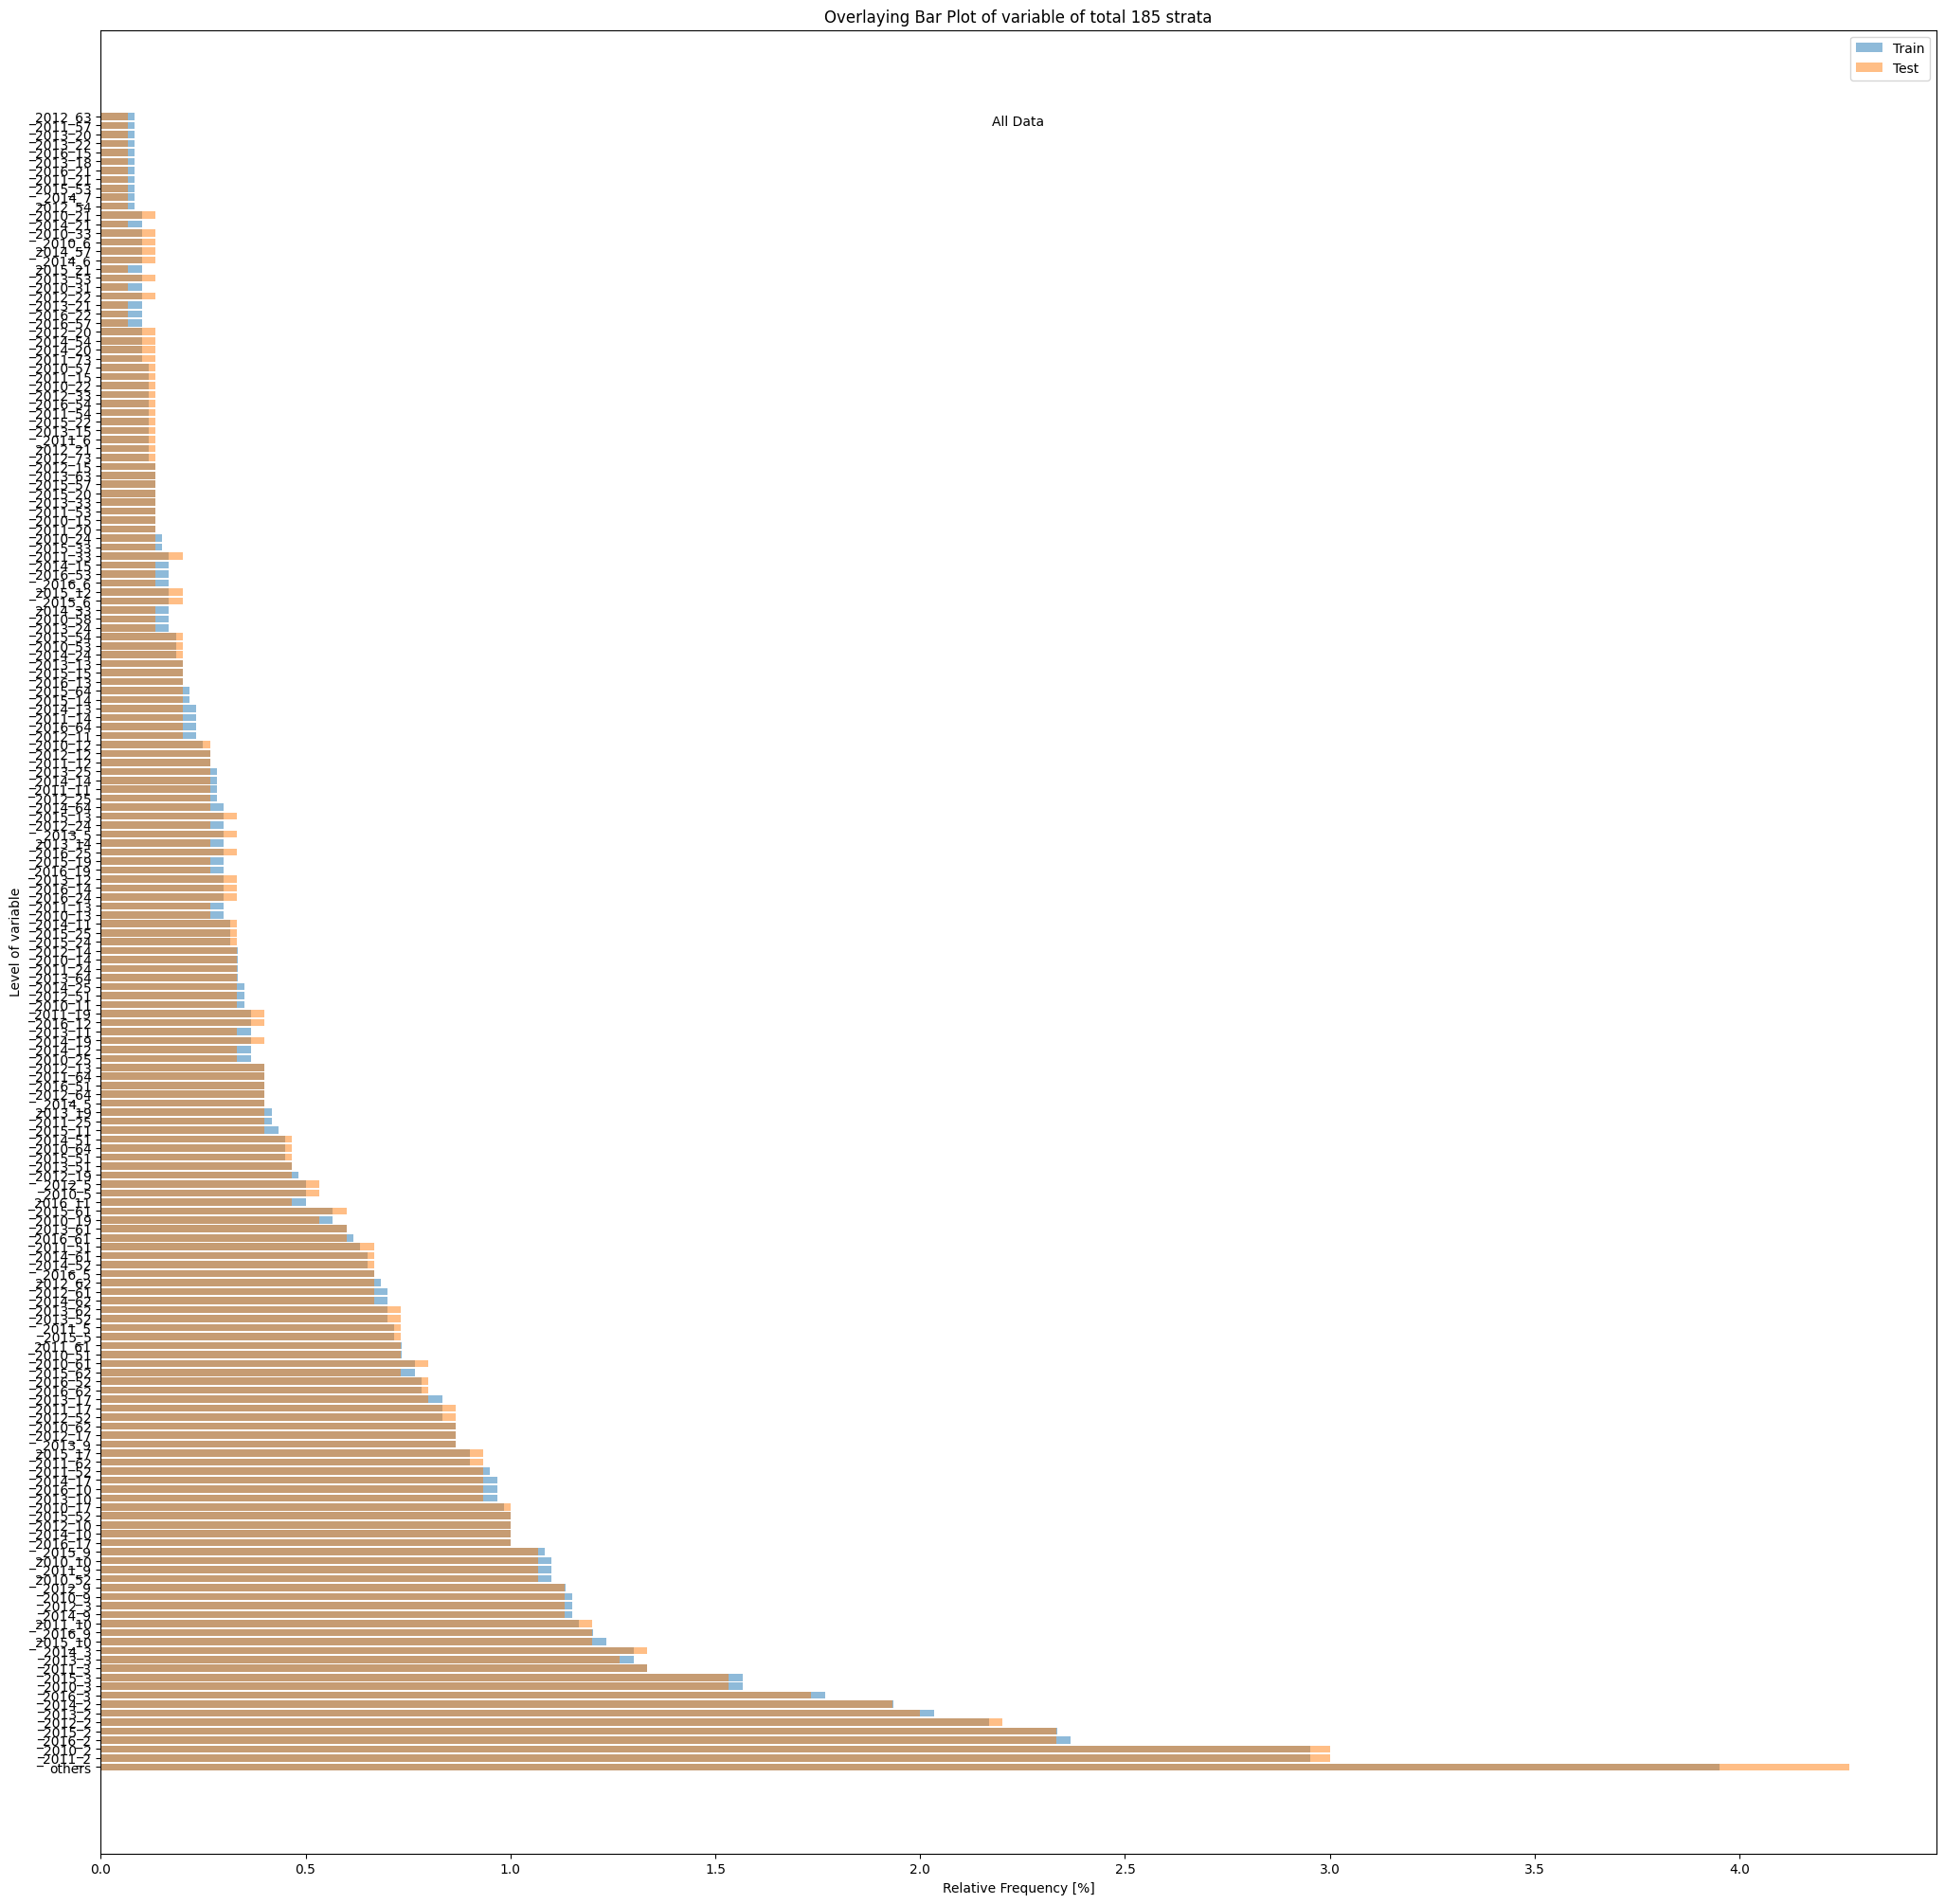

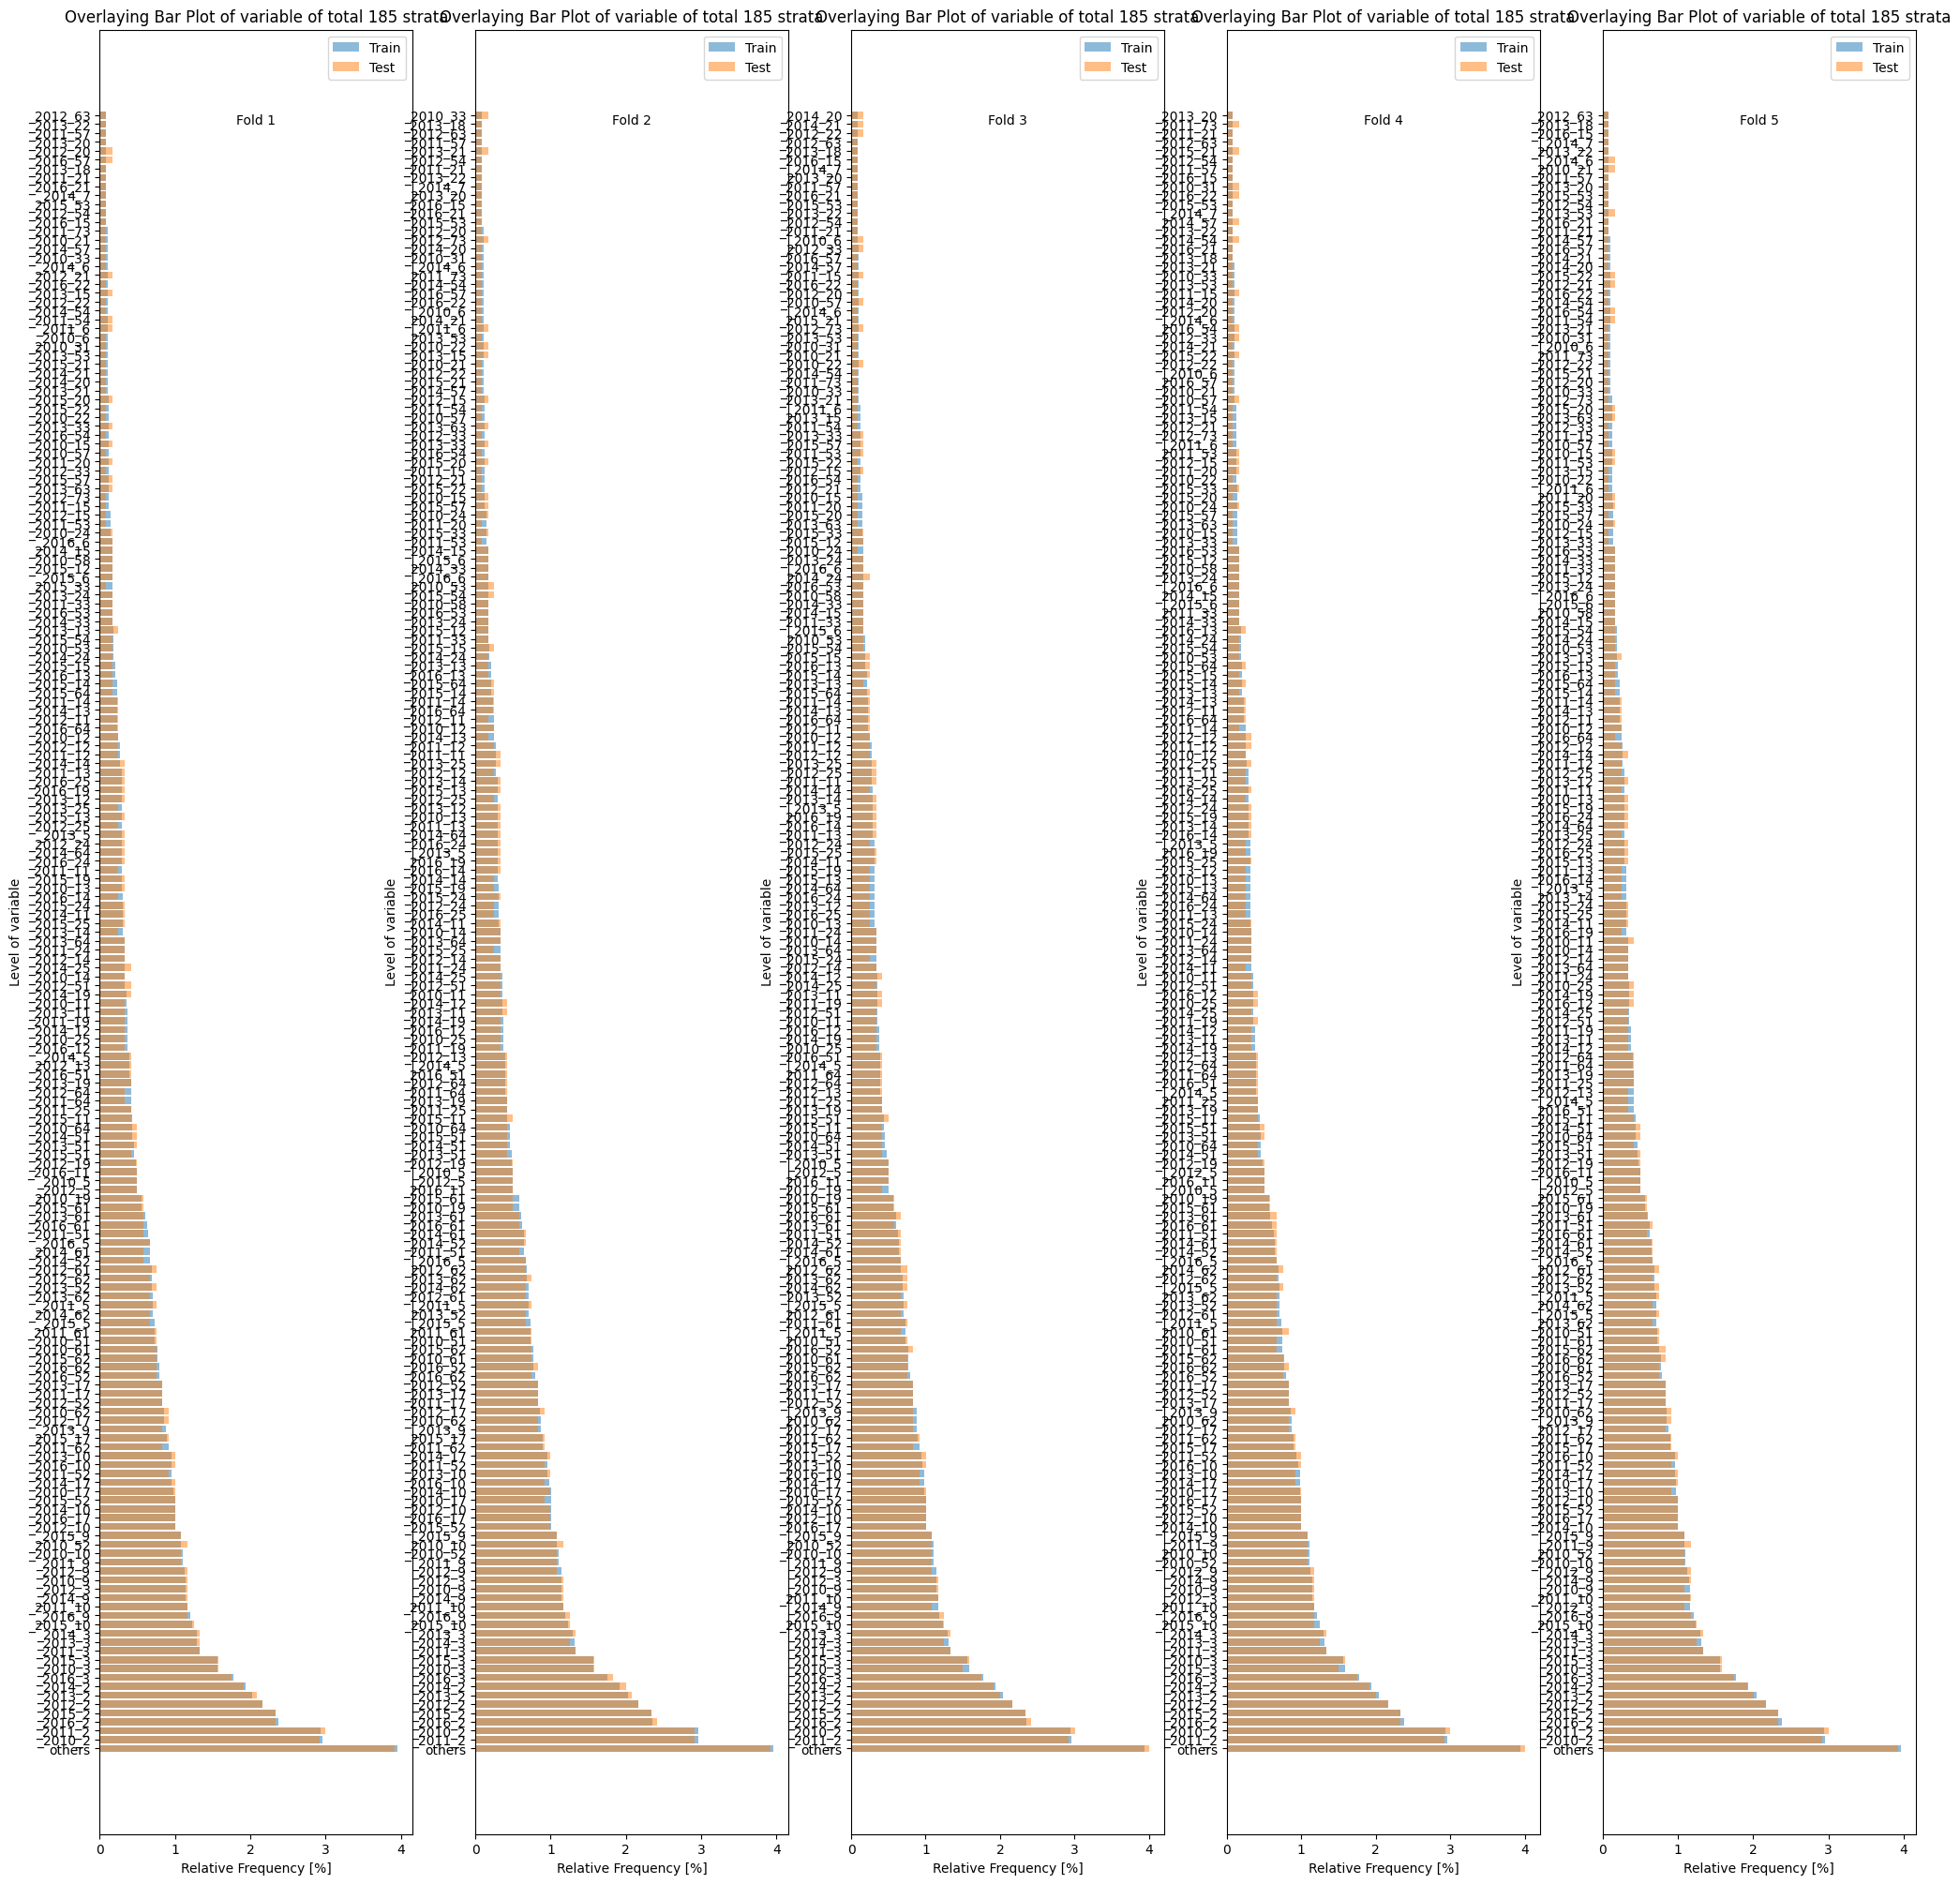

In [358]:
df_aggregated_strata = aggregate_strata_with_too_little_obs(
    Xy_in=df_dropped_rows_with_nas,
    strata_vars=test_train_strata,
    do_fold_too=True,
    split_test=test_split,
    cv_fold=user_input["cv_folds"],
)

### Filter Columns

- Note that apriori filter based on google sheet is done above when encoding NFI variables

#### based on %NAs

In [359]:
# DROP COLUMNS WITH TOO MANY NA VALUES

# Get temporary df for cell
df_tmp = df_aggregated_strata.copy()

# Unify encoding of missing data (NA into NaN)
df_tmp = df_tmp.fillna(value=pd.NA)

# Get number of rows of dataframe to calculate percentages
n_rows = df_tmp.shape[0]

print("Variables that were dropped because they have too many NAs:")
for my_col in sorted(df_tmp.columns):
    n_na = df_tmp[my_col].isna().sum()
    na_perc = n_na / n_rows

    if na_perc > na_drop_threshold:
        df_tmp = df_tmp.drop(my_col, axis=1)
        print(f" - {my_col:<20} with {n_na:<5} NAs ({round(na_perc*100)}%).")

df_dropped_na_cols = df_tmp.copy()

print("")
print(
    f"👉 df shape changed from: {df_aggregated_strata.shape} to {df_dropped_na_cols.shape}",
    end="",
)
print(
    f" = {df_aggregated_strata.shape[1] - df_dropped_na_cols.shape[1]} variables were dropped."
)

Variables that were dropped because they have too many NAs:
 - acces                with 7497  NAs (100%).
 - autut_1              with 6369  NAs (85%).
 - autut_2              with 1222  NAs (16%).
 - bois_1               with 5308  NAs (71%).
 - bois_2               with 1217  NAs (16%).
 - cam                  with 7480  NAs (100%).
 - cslisi               with 5574  NAs (74%).
 - dcespar1             with 7463  NAs (100%).
 - dcespar2             with 7485  NAs (100%).
 - def5                 with 2377  NAs (32%).
 - dpyr                 with 7497  NAs (100%).
 - elag                 with 7039  NAs (94%).
 - elisi                with 6380  NAs (85%).
 - entp                 with 7333  NAs (98%).
 - hw_day_sum           with 7164  NAs (96%).
 - hw_days_between      with 7485  NAs (100%).
 - hw_dur_max           with 7164  NAs (96%).
 - hw_dur_mean          with 7164  NAs (96%).
 - hw_max_temp          with 7164  NAs (96%).
 - hw_mean_temp         with 7164  NAs (96%).
 - incid_1    

In [360]:
# Get remaining columns with NA values for imputation later
vars_with_na = df_dropped_na_cols.columns[df_dropped_na_cols.isna().any()].tolist()
vars_with_na = vars_with_na
print("Variables still containing NAs:")
for var in vars_with_na:
    print(f" - {var}")

Variables still containing NAs:
 - instp5
 - asperite
 - dist
 - gest
 - pentexp
 - plisi
 - portance
 - land_use
 - top1_species_age13_mean
 - top1_species_ba_1_sd
 - top1_species_htot_mean
 - top1_species_htot_sd
 - top1_species_ir5_mean
 - top1_species_v_sd
 - mort_stems_prc_yr_hoshino
 - rec_stems_prc_yr_hoshino
 - mort_ba_prc_yr_hoshino
 - tot_growth_ba_prc_yr_hoshino
 - sur_growth_ba_prc_yr_hoshino
 - tot_growth_ba_prc_yr
 - sur_growth_ba_prc_yr
 - max_gdd_before_spring_frost
 - min_doy_of_fall_frost
 - hw_counts
 - mean_of_minimum_2m_air_temperature_in_winter
 - mean_of_minimum_2m_air_temperature_in_spring
 - mean_of_minimum_2m_air_temperature_in_summer
 - mean_of_minimum_2m_air_temperature_in_fall
 - mean_of_total_precipitation_in_winter
 - mean_of_total_precipitation_in_spring
 - mean_of_total_precipitation_in_summer
 - mean_of_total_precipitation_in_fall
 - mean_of_v_component_of_wind_10m_in_winter
 - mean_of_v_component_of_wind_10m_in_spring
 - mean_of_v_component_of_wind_10

#### based on user input

In [361]:
# TODO: Remove variables that have mostly the same values

In [362]:
# Get temporary df
df_tmp = df_dropped_na_cols.copy()

# Fix user removal input
# If target in variables to remove, remove it
if target in user_input_variable_removal:
    user_input_variable_removal.remove(target)

# If stratification variables in variables to remove, remove them.
# They will be removed later.
for var in test_train_strata:
    if var in user_input_variable_removal:
        user_input_variable_removal.remove(var)

# Remove variables: Setting errors to ignore because some vars may have already been dropped:
print(
    "Variables that have been selected to drop but have been dropped by the routine already: "
)
for var in user_input_variable_removal:
    if var not in df_tmp.columns:
        print(var, end=", ")

df_tmp = df_tmp.drop(columns=user_input_variable_removal, errors="ignore")

# If idp is still in dataframe, remove now explicitly
if "idp" in df_tmp.columns:
    print("Removing idp from dataframe.")
    df_tmp = df_tmp.drop(columns="idp")


df_dropped_user_cols = df_tmp.copy()

print("\n")
print(f"Shape before dropping user selected vars: {df_dropped_na_cols.shape}")
print(f"Shape after dropping user selected vars: {df_dropped_user_cols.shape}")
# print(f"Length of user selected vars to drop: {len(user_input_variable_removal)}") # Does not need to match, so removing

Variables that have been selected to drop but have been dropped by the routine already: 
visite_1, visite_2, census_interval, 

Shape before dropping user selected vars: (7497, 210)
Shape after dropping user selected vars: (7497, 169)


## Get variables to impute

### Encode categorical variables

In [363]:
# ! Output of this cell should be empty because categorical variables with NA values should not be in the data.

# GET CATEGORICAL VARIABLES WITH NA VALUES
# Get all categorical variables that have NAs in them
# cats_with_na = vars_with_na[vars_with_na.isin(vars_to_ohe)].tolist()
cats_with_na = [var for var in vars_with_na if var in vars_to_ohe]

print("Categorical Variables that still have NA (NA will be turned into 'missing'):")
for var in cats_with_na:
    print(" ", var, end=", ")
print("\n")

# Replace NA values with "missing"
for var in cats_with_na:
    df_dropped_user_cols[var] = df_dropped_user_cols[var].fillna("missing")

print("Variables encoded to be categorical:")
for var in vars_to_ohe:
    if var in df_dropped_user_cols.columns:
        df_dropped_user_cols[var] = df_dropped_user_cols[var].astype(str)
        print(f" - {var}", end="\n")

# Make sure idp is kept as int to merge with gee data later
# df_dropped_user_cols["idp"] = df_dropped_user_cols["idp"].astype(int)

Categorical Variables that still have NA (NA will be turned into 'missing'):
  instp5,   land_use, 

Variables encoded to be categorical:
 - andain
 - bord
 - instp5
 - integr
 - iti
 - tplant
 - csa_1
 - csa_2
 - nincid_2
 - cover_change
 - human_activity_var
 - land_use
 - dom_nr1_tree_class_fct
 - dom_nr2_tree_class_fct
 - dom_nr3_tree_class_fct
 - dom_rest_tree_class_fct
 - top1_species_nfi
 - top2_species_nfi
 - top3_species_nfi


In [364]:
# GET NUMERICAL VARIABLES WITH NA VALUES
numerics_with_na = [
    var
    for var in df_dropped_user_cols.columns
    if df_dropped_user_cols[var].dtype != "O"
]  # No categorical variables
numerics_with_na = [
    var for var in numerics_with_na if var not in date_cols
]  # No date time variables
numerics_with_na = [
    var for var in numerics_with_na if var in vars_with_na
]  # Reduce to variables that hold NA values
numerics_with_na = [
    var for var in numerics_with_na if var != target
]  # Make sure target is not in the list

print("Numerical variables with NA values to be imputed:")
counter = 0
for var in numerics_with_na:
    print(f" {counter}. {var}")
    counter = counter + 1

Numerical variables with NA values to be imputed:
 0. asperite
 1. dist
 2. gest
 3. pentexp
 4. plisi
 5. portance
 6. top1_species_age13_mean
 7. top1_species_ba_1_sd
 8. top1_species_htot_mean
 9. top1_species_htot_sd
 10. top1_species_ir5_mean
 11. top1_species_v_sd
 12. max_gdd_before_spring_frost
 13. min_doy_of_fall_frost
 14. hw_counts
 15. mean_of_minimum_2m_air_temperature_in_winter
 16. mean_of_minimum_2m_air_temperature_in_spring
 17. mean_of_minimum_2m_air_temperature_in_summer
 18. mean_of_minimum_2m_air_temperature_in_fall
 19. mean_of_total_precipitation_in_winter
 20. mean_of_total_precipitation_in_spring
 21. mean_of_total_precipitation_in_summer
 22. mean_of_total_precipitation_in_fall
 23. mean_of_v_component_of_wind_10m_in_winter
 24. mean_of_v_component_of_wind_10m_in_spring
 25. mean_of_v_component_of_wind_10m_in_summer
 26. mean_of_v_component_of_wind_10m_in_fall
 27. mean_of_surface_pressure_in_winter
 28. mean_of_surface_pressure_in_spring
 29. mean_of_surface

## ✂️ Split Data

### Do Split

In [365]:
# Get temporary df
df_tmp = df_dropped_user_cols.copy()

# Get all variables names before one-hot encoding
all_var_names_before_ohe = sorted(df_tmp.columns.to_list())

# Set variables to not ohe:
my_vars_not_to_ohe = ["test_train_strata"]

# Do the OHE
df_tmp = do_ohe(df_tmp, my_vars_not_to_ohe, verbose=True)

# Get all variables names after one-hot encoding
all_var_names_after_ohe = sorted(df_tmp.columns.to_list())

# Get variable dictionary
var_ohe_dict = {}
for var in all_var_names_before_ohe:
    sub_vars = []

    if var in all_var_names_after_ohe:
        # If the variable was not ohe, it stays the same
        var_ohe_dict[var] = [var]
        continue
    else:
        # If the variable was ohe, search for pattern and add it
        pattern = r"^" + var + r"_.*"
        for sub_var in all_var_names_after_ohe:
            # print(pattern, sub_var, re.match(pattern, sub_var))
            if re.match(pattern, sub_var):
                sub_vars.append(sub_var)
    var_ohe_dict[var] = sub_vars

do_ohe(): 
 - Shape before OHE:		 (7497, 169) 
 - Shape after OHE:		 (7497, 381) 
 - Change in Nr. of columns:	 212 (dropped: 19, added: 231) 
 - Variables that were ohe:	 andain | bord | cover_change | csa_1 | csa_2 | dom_nr1_tree_class_fct | dom_nr2_tree_class_fct | dom_nr3_tree_class_fct | dom_rest_tree_class_fct | human_activity_var | instp5 | integr | iti | land_use | nincid_2 | top1_species_nfi | top2_species_nfi | top3_species_nfi | tplant 
 - New variables:		 andain_0 | andain_1 | bord_0 | bord_1 | cover_change_Clearcut | cover_change_Decreased Tree Cover | cover_change_Increased Tree Cover | cover_change_No Change | csa_1_1 | csa_1_2 | csa_1_3 | csa_1_5 | csa_2_1 | csa_2_2 | csa_2_3 | csa_2_5 | csa_2_7 | dom_nr1_tree_class_fct_broadleaf | dom_nr1_tree_class_fct_pinus | dom_nr2_tree_class_fct_broadleaf | dom_nr2_tree_class_fct_none | dom_nr2_tree_class_fct_pinus | dom_nr3_tree_class_fct_none | dom_rest_tree_class_fct_none | human_activity_var_DEF5 | human_activity_var_GEST | hu

In [366]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_tmp.drop(target, axis=1),
    df_tmp[target],
    test_size=test_split,
    random_state=seed_nr,
    stratify=df_tmp["test_train_strata"],
)

# Merge dataframes back for easier handling
Xy_train_raw = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
Xy_test_raw = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(
    f"Shape of Xy_train_raw: {Xy_train_raw.shape}",
    f"\nShape of Xy_test_raw: {Xy_test_raw.shape}",
)

Shape of Xy_train_raw: (5997, 381) 
Shape of Xy_test_raw: (1500, 381)


## Preprocessing

In [367]:
Xy_train_imputed, Xy_test_imputed = impute_numerical_na(
    Xy_train_raw,
    Xy_test_raw,
    target,
    n_neighbours=10,
    vars_not_to_impute=test_train_strata,
)

impute_numerical_na(): 
 - Shape of Xy_train before imputation: (5997, 381) 
 - Shape of Xy_train before imputation: (5997, 381) 
 
 - Shape of Xy_test before imputation: (1500, 381) 
 - Shape of Xy_test before imputation: (1500, 381) 
 
 - Out of 380, 123 had NA values and were imputed using KNN with 10 neighbours. 
 - Imputed variables: asperite | dist | gest | hw_counts | max_gdd_before_spring_frost | mean_of_dewpoint_2m_temperature_in_fall | mean_of_dewpoint_2m_temperature_in_spring | mean_of_dewpoint_2m_temperature_in_summer | mean_of_dewpoint_2m_temperature_in_winter | mean_of_landsat_EVI_in_fall | mean_of_landsat_EVI_in_spring | mean_of_landsat_EVI_in_summer | mean_of_landsat_EVI_in_winter | mean_of_landsat_NDVI_in_fall | mean_of_landsat_NDVI_in_spring | mean_of_landsat_NDVI_in_summer | mean_of_landsat_NDVI_in_winter | mean_of_maximum_2m_air_temperature_in_fall | mean_of_maximum_2m_air_temperature_in_spring | mean_of_maximum_2m_air_temperature_in_summer | mean_of_maximum_2m_air_

## Fit Model

#### Get preset parameters if needed

### Random Grid Search

NEEDS MAJOR UPDATE!

In [368]:
if user_input["do_random_search"]:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import RandomizedSearchCV

    # Number of trees in random forest
    # n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    n_estimators = [int(x) for x in np.linspace(start=10, stop=2500, num=5)]

    # Number of features to consider at every split
    max_features = ["auto", "sqrt"]

    # Maximum number of levels in tree
    # max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth = [int(x) for x in np.linspace(1, 50, num=5)]
    # max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        # "bootstrap": bootstrap,
    }

    for key, value in random_grid.items():
        print(f"{key}: {value}")

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()

    # Random search of parameters, using 3 fold cross validation,
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(
        estimator=rf,
        param_distributions=random_grid,
        n_iter=100,
        cv=5,
        verbose=1,
        random_state=seed_nr,
        n_jobs=-1,
        return_train_score=True,
    )

    # Fit the random search model
    rf_random.fit(
        X_train,
        y_train,
        sample_weight=get_weights_from_y(y_train, user_input["weight_method"]),
    )

    # Print results
    print(
        rf_random.best_estimator_
    )  # Output: RandomForestRegressor(max_features='sqrt', n_estimators=1255)
    print(rf_random.best_score_)  # Output: 0.18764794450728156
    print(rf_random.best_params_)

### Prescribed Grid Search

In [369]:
if user_input["do_prescribed_search"]:
    # Get dataframes
    Xy_train_final = Xy_train_imputed.copy()
    test_train_strata = Xy_train_final["test_train_strata"].to_list()
    X_train_final = Xy_train_final.drop(columns=[target, "test_train_strata"])
    y_train_final = Xy_train_final[target]

    # Define the parameter grid
    param_grid = {
        "n_estimators": [
            10,
            50,
            100,
            250,
            500,
            # 1000,
        ],  # , 1000, 2000, 5000],  # 500, 1000, 2500],
        "max_features": [
            "sqrt",
            "log2",
            0.1,
            0.15,
            0.2,
            # 0.4,
            # 0.6,
            # 0.8,
        ],  # ["sqrt", "log2"],  # ["auto", "sqrt", "log2"],
        "max_depth": [5, 6, 8, 15, 25, 30, 50],  # 10],  # , 50, 100],
        "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    }

    # Use StratifiedKFold with your stratifying variable
    stratified_kfold = StratifiedKFold(n_splits=user_input["cv_folds"], shuffle=True)

    # Make sure the stratifying variable is used here
    folds = list(stratified_kfold.split(X_train_final, test_train_strata))

    # Create a base model
    rf = RandomForestRegressor()

    # Instantiate the grid search model
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=folds,
        n_jobs=-1,
        verbose=1,
        return_train_score=True,
    )

    # Fit the grid search to the data
    grid_search.fit(
        X_train_final,
        y_train_final,
        sample_weight=get_weights_from_y(y_train_final, user_input["weight_method"]),
    )

    # Print results
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    best_params = grid_search.best_params_

    plot_grid_search_results(grid_search)

In [370]:
# {'n_estimators': 200, 'max_features': 0.2, 'max_depth': 25, 'bootstrap': True}

### Preset Best Hyperparameters

In [371]:
if not user_input["do_prescribed_search"] and not user_input["do_random_search"]:
    # Return best variables from previous search
    best_params = {
        "n_estimators": 250,
        # "min_samples_split": 2,
        # "min_samples_leaf": 1,
        "max_features": "sqrt",
        "max_depth": 25,
        "bootstrap": True,
        "criterion": "friedman_mse",  # ["squared_error", "absolute_error", "friedman_mse", "poisson"]
    }

best_params

{'n_estimators': 250,
 'max_features': 'sqrt',
 'max_depth': 25,
 'bootstrap': True,
 'criterion': 'friedman_mse'}

### 🔄 REFCV

In [372]:
if user_input["do_ref"]:
    # Set parameters
    debug_stop = False
    debug_stop_after_n_iterations = 10

    ohe_vars_to_remove = []
    non_ohe_vars_to_remove = []
    new_ohe_vars_to_remove = []
    new_non_ohe_vars_to_remove = []

    ohe_vars_to_remove_n = 0
    non_ohe_vars_to_remove_n = 0
    new_ohe_vars_to_remove_n = 0
    new_non_ohe_vars_to_remove_n = 0

    cv_folds = user_input["cv_folds"]
    features_to_remove_above100 = 10
    features_to_remove_above50 = 5
    features_to_remove_above30 = 3
    features_to_remove_below30 = 1

    # --------------------------------------------------------
    # Prepare final dataframe:
    df_cvmetrics_per_nfeatures = pd.DataFrame(
        {
            "n_features": [],
            "r2": [],
            "r2_sd": [],
            "rmse": [],
            "rmse_sd": [],
            "mae": [],
            "mae_sd": [],
            "vars_to_remove": [],
        },
    )

    # Original number of features (not-ohe)
    # Code below reduces the var_ohe_dict to keys where a value
    # matches a column in X_train_imputed.
    reduced_var_ohe_dict = {
        key: value
        for key, value in var_ohe_dict.items()
        if any(col in Xy_train_imputed.columns for col in value)
    }
    # Remove target and strata from the dictionary
    reduced_var_ohe_dict.pop(target, None)
    reduced_var_ohe_dict.pop("test_train_strata", None)

    original_number_of_features = len(reduced_var_ohe_dict)
    remaining_features_numbers = original_number_of_features

    # Set iteration counter
    iteration_count = 1

    # --------------------------------------------------------
    # START REF-CV
    # --------------------------------------------------------
    while True:
        # Set vectors to track metrics
        v_r2 = []
        v_rmse = []
        v_mae = []

        # --------------------------------------------------------
        # CROSS-VALIDATION
        # --------------------------------------------------------

        # Remove variables of previous iteration
        Xy_refcv = (
            Xy_train_imputed.copy()
            .drop(columns=ohe_vars_to_remove)
            .reset_index(drop=True)
        )

        # Get current number of features
        remaining_features_numbers = (
            original_number_of_features - non_ohe_vars_to_remove_n
        )

        print(
            f"\n⭐ Iteration {iteration_count} ---------------------------------------------------------",
            f"\n - Current Number of features: {original_number_of_features} - {non_ohe_vars_to_remove_n} = {remaining_features_numbers}",
        )

        # If no more features to remove, break loop
        if (remaining_features_numbers) == 0:
            break

        # Create folds
        skf = StratifiedKFold(
            n_splits=cv_folds, shuffle=True
        )  # TODO: Check if seed should be fixed or not.

        print("\n - Do cross-validation...", end=" ")

        # Create stratified folds
        for fold, (train_index, test_index) in enumerate(
            skf.split(Xy_refcv, Xy_refcv["test_train_strata"])
        ):
            # Get current fold
            Xy_refcv_train, Xy_refcv_val = (
                Xy_refcv.iloc[train_index],
                Xy_refcv.iloc[test_index],
            )

            # Preprocess data (Removed. Do this only on the original full dataset!)

            # Split into X and y
            X_train_if = Xy_refcv_train.drop(
                columns=[target, "test_train_strata"],
                errors="ignore",
            )
            y_train_if = Xy_refcv_train[target]

            X_val_if = Xy_refcv_val.drop(
                columns=[target, "test_train_strata"],
                errors="ignore",
            )
            y_val_if = Xy_refcv_val[target]

            # Print information
            print(
                f"\n  - Fold {fold + 1} | {cv_folds}:",
                # f"\t | Validation/Test = {round(len(Xy_refcv_val) / (len(Xy_refcv_val) + len(Xy_refcv_train)) * 100)}/{round(len(Xy_refcv_train) / (len(Xy_refcv_val) + len(Xy_refcv_train)) * 100)}",
                # f"\t | Shape of X_train_if: {X_train_if.shape} and y_train_if: {y_train_if.shape}",
                # f"\t | Shape of X_val_if: {X_val_if.shape} and y_val_if: {y_val_if.shape}",
                end=" | ",
            )

            # Fit model
            print(f"\tFit model...", end=" ")
            rf_rfe = RandomForestRegressor(
                **best_params, random_state=seed_nr, n_jobs=-1
            )
            rf_rfe.fit(
                X_train_if,
                y_train_if,
                get_weights_from_y(y_train_if, user_input["weight_method"]),
            )

            # Get metrics on validation set
            y_pred_val = rf_rfe.predict(X_val_if)
            v_r2 = v_r2 + [r2_score(y_val_if, y_pred_val)]
            v_rmse = v_rmse + [np.sqrt(mean_squared_error(y_val_if, y_pred_val))]
            v_mae = v_mae + [mean_absolute_error(y_val_if, y_pred_val)]

            # --------------------------------------------------------
            # End of fold
            # --------------------------------------------------------

        # --------------------------------------------------------
        # FEATURE IMPORTANCE
        # --------------------------------------------------------
        # Calculate feature importance
        print(f"\n - Run model on full dataset...", end="")
        rf_fin = RandomForestRegressor(**best_params, random_state=seed_nr, n_jobs=-1)
        rf_rfe.fit(
            Xy_refcv_train.drop(
                columns=[target, "test_train_strata"],
                errors="ignore",
            ),
            Xy_refcv_train[target],
            sample_weight=get_weights_from_y(
                Xy_refcv_train[target], user_input["weight_method"]
            ),
        )

        print(f"\n - Calculate feature importance...\n", end="")
        agg_vip = assessing_top_predictors(
            rf_in=rf_rfe,
            ignore_these=[target, "test_train_strata"],
            X_train_in=Xy_refcv_train,
            dict_ohe_in=var_ohe_dict,
            with_aggregation=True,
            n_predictors=20,
            verbose=False,
        )

        # Set number of variables to remove
        n_to_remove = features_to_remove_below30

        if remaining_features_numbers > 30:
            n_to_remove = features_to_remove_above30

        if remaining_features_numbers > 50:
            n_to_remove = features_to_remove_above50

        if remaining_features_numbers > 100:
            n_to_remove = features_to_remove_above100

        # --------------------------------------------------------
        # VARIABLE REMOVAL
        # TODO: Should we remove all sub-levels of an important aggregated variable or not?
        # Get names and length of variables in their ohe form
        new_ohe_vars_to_remove = agg_vip.tail(n_to_remove)["Vars_in_key"].to_list()
        # Unlist nested lists
        new_ohe_vars_to_remove = [
            item for sublist in new_ohe_vars_to_remove for item in sublist
        ]
        new_ohe_vars_to_remove_n = len(new_ohe_vars_to_remove)

        # Add to list of variables to remove
        ohe_vars_to_remove = new_ohe_vars_to_remove + ohe_vars_to_remove
        ohe_vars_to_remove_n = len(ohe_vars_to_remove)

        # Do the same for the non-ohe variable names
        new_non_ohe_vars_to_remove = agg_vip.tail(n_to_remove)["Feature"].to_list()
        new_non_ohe_vars_to_remove_n = len(new_non_ohe_vars_to_remove)

        # No unlisting needed
        non_ohe_vars_to_remove = new_non_ohe_vars_to_remove + non_ohe_vars_to_remove
        non_ohe_vars_to_remove_n = len(non_ohe_vars_to_remove)
        # --------------------------------------------------------
        # VARIABLE IN MODEL
        ohe_vars_in_model = Xy_refcv_train.drop(
            columns=[target, "test_train_strata"],
            errors="ignore",
        ).columns.to_list()
        ohe_vars_in_model_n = len(ohe_vars_in_model)

        # Cross-check ohe_vars_in_model with the values in var_ohe_dict and return key if there is a match
        non_ohe_vars_in_model = [
            key
            for key, value in var_ohe_dict.items()
            if any(col in ohe_vars_in_model for col in value)
        ]
        non_ohe_vars_in_model = list(set(non_ohe_vars_in_model))
        non_ohe_vars_in_model_n = len(non_ohe_vars_in_model)

        print(
            f"\n - For one-hot-encoded variable names:",
            f"\n   - New variables to remove (ohe-encoded-names): {new_ohe_vars_to_remove_n}\t|{new_ohe_vars_to_remove}",
            f"\n   - All variables to remove (ohe-encoded-names): {ohe_vars_to_remove_n}\t|{ohe_vars_to_remove}",
            f"\n\n - For original variable names:",
            f"\n   - New variables to remove (original-names): {new_non_ohe_vars_to_remove_n}\t|{new_non_ohe_vars_to_remove}",
            f"\n   - All variables to remove (original-names): {non_ohe_vars_to_remove_n}\t|{non_ohe_vars_to_remove}",
            f"\n\n - Variables in model",
            f"\n   - ohe-encoded-names\t{ohe_vars_in_model_n}\t| {ohe_vars_in_model}",
            f"\n   - original-names\t{non_ohe_vars_in_model_n}\t| {non_ohe_vars_in_model}",
            f"\n\n - Metrics:",
            f"\n   - r2: {round(np.mean(v_r2), 2)} (+- {round(np.std(v_r2), 2)})",
            f"\n   - rmse: {round(np.mean(v_rmse), 2)} (+- {round(np.std(v_rmse), 2)})",
            f"\n   - mae: {round(np.mean(v_mae), 2)} (+- {round(np.std(v_mae), 2)})",
        )

        # --------------------------------------------------------
        # Save to output
        # --------------------------------------------------------
        # Save rf metrics for current number of features

        df_new_row = pd.DataFrame(
            {
                "n_features": [remaining_features_numbers],
                "r2": np.mean(v_r2),
                "r2_sd": np.std(v_r2),
                "rmse": np.mean(v_rmse),
                "rmse_sd": np.std(v_rmse),
                "mae": np.mean(v_mae),
                "mae_sd": np.std(v_mae),
                # Numbers
                "new_ohe_vars_to_remove_n": new_ohe_vars_to_remove_n,
                "new_non_ohe_vars_to_remove_n": new_non_ohe_vars_to_remove_n,
                "ohe_vars_to_remove_n": ohe_vars_to_remove_n,
                "non_ohe_vars_to_remove_n": non_ohe_vars_to_remove_n,
                "ohe_vars_in_model_n": ohe_vars_in_model_n,
                "non_ohe_vars_in_model_n": non_ohe_vars_in_model_n,
                # Lists
                "new_ohe_vars_to_remove": [new_ohe_vars_to_remove],
                "new_non_ohe_vars_to_remove": [new_non_ohe_vars_to_remove],
                "ohe_vars_to_remove": [ohe_vars_to_remove],
                "non_ohe_vars_to_remove": [non_ohe_vars_to_remove],
                "ohe_vars_in_model": [Xy_refcv_train.columns],
                "ohe_vars_in_model": [ohe_vars_in_model],
                "non_ohe_vars_in_model": [non_ohe_vars_in_model],
            }
        )

        # display(df_new_row)

        df_cvmetrics_per_nfeatures = pd.concat(
            [df_cvmetrics_per_nfeatures, df_new_row], axis=0
        )

        iteration_count = iteration_count + 1

        if debug_stop and iteration_count == debug_stop_after_n_iterations:
            break

In [373]:
# if user_input["do_ref"]:
#     display(df_cvmetrics_per_nfeatures)

In [374]:
if user_input["do_ref"]:
    # Get max number of features
    x_max = df_cvmetrics_per_nfeatures["n_features"].max()

    # Start plotting
    fig, axs = plt.subplots(3, 1, figsize=(7, 7))

    # PLOT: R2 ----------------------------------------------
    # Get max R2
    max_r2 = df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False).iloc[0, 1]
    # Get n_features at max R2
    max_r2_features = df_cvmetrics_per_nfeatures.sort_values(
        by="r2", ascending=False
    ).iloc[0, 0]
    axs[0].plot(
        df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["r2"]
    )
    axs[0].fill_between(
        df_cvmetrics_per_nfeatures["n_features"],
        df_cvmetrics_per_nfeatures["r2"] - df_cvmetrics_per_nfeatures["r2_sd"],
        df_cvmetrics_per_nfeatures["r2"] + df_cvmetrics_per_nfeatures["r2_sd"],
        alpha=0.3,
    )
    axs[0].set_xlabel("Number of Features")
    axs[0].set_ylabel("R2 Score")
    axs[0].set_xlim(x_max, 0)
    axs[0].set_ylim(0, (max_r2 + max_r2 * 0.1))

    # Add red vertical line for highest R2 score
    axs[0].axvline(x=max_r2_features, color="red")

    # Add text of max_r2_features to axs[0] in red
    axs[0].text(
        x_max - 5,
        max_r2 * 0.1,
        f"Optimal Nr. of Features: {int(max_r2_features)} at R2 = {round(max_r2,2)}",
        color="red",
    )

    # PLOT: RMSE ----------------------------------------------
    # Get min rmse
    min_rmse = df_cvmetrics_per_nfeatures.sort_values(by="rmse", ascending=True).iloc[
        0, 3
    ]
    max_rmse = df_cvmetrics_per_nfeatures.sort_values(by="rmse", ascending=False).iloc[
        0, 3
    ]

    # Get n_features at min rmse
    min_rmse_features = df_cvmetrics_per_nfeatures.sort_values(
        by="rmse", ascending=True
    ).iloc[0, 0]

    axs[1].plot(
        df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["rmse"]
    )
    axs[1].fill_between(
        df_cvmetrics_per_nfeatures["n_features"],
        df_cvmetrics_per_nfeatures["rmse"] - df_cvmetrics_per_nfeatures["rmse_sd"],
        df_cvmetrics_per_nfeatures["rmse"] + df_cvmetrics_per_nfeatures["rmse_sd"],
        alpha=0.3,
    )
    axs[1].set_xlabel("Number of Features")
    axs[1].set_ylabel("RMSE")
    axs[1].set_xlim(x_max, 0)
    axs[1].set_ylim(0, (max_rmse + max_rmse * 0.1))

    # Add red vertical line for lowest RMSE score
    axs[1].axvline(x=min_rmse_features, color="red")

    # Add text
    axs[1].text(
        x_max - 5,
        min_rmse * 0.1,
        f"Optimal Nr. of Features: {int(min_rmse_features)} at RMSE = {round(min_rmse,2)}",
        color="red",
    )

    # PLOT: MAE ----------------------------------------------
    min_mae = df_cvmetrics_per_nfeatures.sort_values(by="mae", ascending=True).iloc[
        0, 5
    ]
    max_mae = df_cvmetrics_per_nfeatures.sort_values(by="mae", ascending=False).iloc[
        0, 5
    ]
    min_mae_features = df_cvmetrics_per_nfeatures.sort_values(
        by="mae", ascending=True
    ).iloc[0, 0]

    axs[2].plot(
        df_cvmetrics_per_nfeatures["n_features"], df_cvmetrics_per_nfeatures["mae"]
    )
    axs[2].fill_between(
        df_cvmetrics_per_nfeatures["n_features"],
        df_cvmetrics_per_nfeatures["mae"] - df_cvmetrics_per_nfeatures["mae_sd"],
        df_cvmetrics_per_nfeatures["mae"] + df_cvmetrics_per_nfeatures["mae_sd"],
        alpha=0.3,
    )
    axs[2].set_xlabel("Number of Features")
    axs[2].set_ylabel("MAE")
    axs[2].set_xlim(x_max, 0)
    axs[2].set_ylim(0, (max_mae + max_mae * 0.1))

    # Add red vertical line for lowest RMSE score
    axs[2].axvline(x=min_mae_features, color="red")

    # Add text
    axs[2].text(
        x_max - 5,
        min_mae * 0.1,
        f"Optimal Nr. of Features: {int(min_mae_features)} at MAE = {round(min_mae,2)}",
        color="red",
    )

    # LAYOUT
    plt.tight_layout()
    plt.show()

In [375]:
if user_input["do_ref"]:
    ohed_variables_in_best_model = (
        df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False)
        .head(1)["ohe_vars_in_model"]
        .values[0]
    )
    non_ohed_variables_in_best_model = (
        df_cvmetrics_per_nfeatures.sort_values(by="r2", ascending=False)
        .head(1)["non_ohe_vars_in_model"]
        .values[0]
    )

    print(
        f"Variables in best model (ohe): {ohed_variables_in_best_model}",
        f"\nVariables in best model (non-ohe): {non_ohed_variables_in_best_model}",
    )

## Final model

### Fit

In [376]:
if user_input["do_ref"]:
    keep_these_vars = ohed_variables_in_best_model + [target, "test_train_strata"]

    Xy_train_final = Xy_train_imputed.copy()[keep_these_vars]
    Xy_test_final = Xy_test_imputed.copy()[keep_these_vars]
else:
    Xy_train_final = Xy_train_imputed.copy()
    Xy_test_final = Xy_test_imputed.copy()

In [377]:
# Make sure to remove stratification and target from X_train_final and X_test_final
X_train_final = Xy_train_final.drop(columns=[target, "test_train_strata"])
X_test_final = Xy_test_final.drop(columns=[target, "test_train_strata"])

y_train_final = Xy_train_final[target]
y_test_final = Xy_test_final[target]

In [378]:
# Fit the model to the training data
rf_best = RandomForestRegressor(
    **best_params, random_state=seed_nr, n_jobs=-1
)  # Create best model
rf_best.fit(
    X_train_final,
    y_train_final,
    sample_weight=get_weights_from_y(y_train_final, user_input["weight_method"]),
)

RandomForestRegressor(criterion='friedman_mse', max_depth=25,
                      max_features='sqrt', n_estimators=250, n_jobs=-1,
                      random_state=42)

### Mod-Obs

Train Data:
 - R2 score:	  0.64
 - RMSE:	  0.77
 - MAE:		  0.36

Test Data:
 - R2 score:	  0.14
 - RMSE:	  1.1
 - MAE:		  0.51


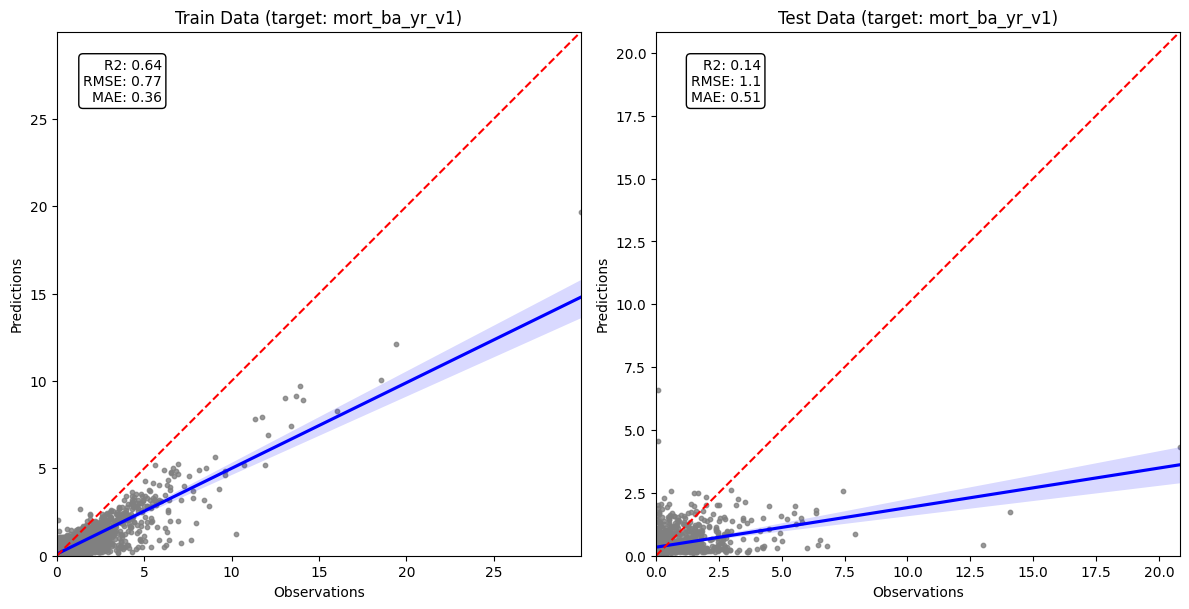

In [379]:
model_evaluation_2(rf_best, X_train_final, y_train_final, X_test_final, y_test_final)

### Variable Importance

#### Without aggregation

In [380]:
if user_input["do_ref"]:
    show_top_n = int(max_r2_features)
else:
    show_top_n = 20

assessing_top_predictors()... 
 - Number of columns in X_train_in is equal to number of rows in df_featimp_org: True 
 - Number of vars in training set is equal to number of rows in df_featimp_agg: False 
 - Size of original df_featimp_org: (379, 3) 
 - Size of aggregated df_featimp_agg: (0, 3)


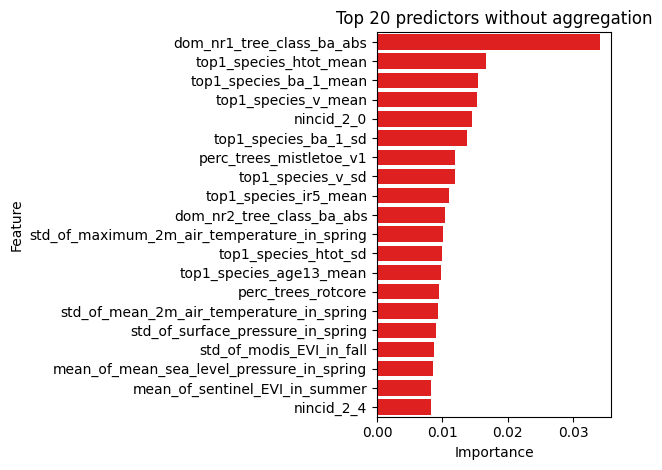

In [381]:
# show_top_predictors(X_train_fin, vars_to_ohe, rf_best, with_aggregation=False)
df_featimp_noagg = assessing_top_predictors(
    rf_in=rf_best,
    ignore_these=[target, "test_train_strata"],
    X_train_in=X_train_final,
    dict_ohe_in=var_ohe_dict,
    with_aggregation=False,
    n_predictors=show_top_n,
    verbose=True,
)

#### With aggregation

assessing_top_predictors()... 
 - Number of columns in X_train_in is equal to number of rows in df_featimp_org: True 
 - Number of vars in training set is equal to number of rows in df_featimp_agg: True 
 - Size of original df_featimp_org: (379, 3) 
 - Size of aggregated df_featimp_agg: (167, 6)


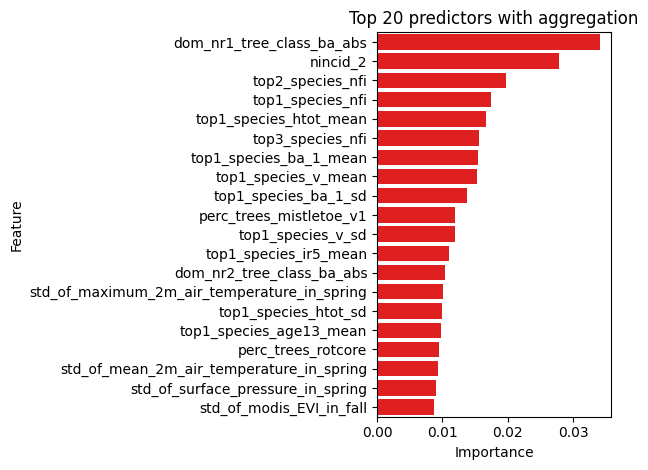

In [382]:
# show_top_predictors(X_train_fin, vars_to_ohe, rf_best, with_aggregation=True)
df_featimp_withagg = assessing_top_predictors(
    rf_in=rf_best,
    ignore_these=[target, "test_train_strata"],
    X_train_in=X_train_final,
    dict_ohe_in=var_ohe_dict,
    with_aggregation=True,
    n_predictors=show_top_n,
    verbose=True,
)

## Partial Dependence Plots

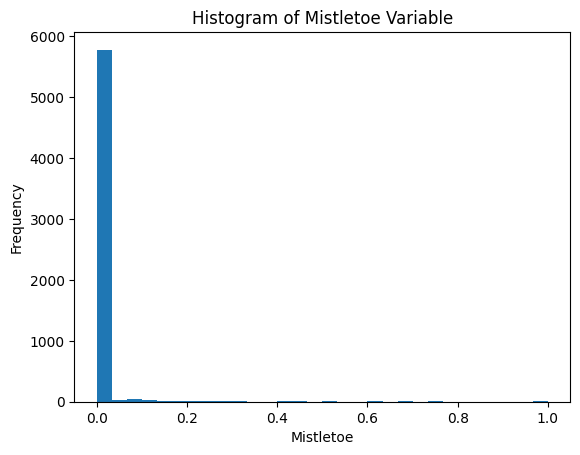

In [512]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(X_train_final["perc_trees_mistletoe_v1"], bins=30)
plt.xlabel("Mistletoe")
plt.ylabel("Frequency")
plt.title("Histogram of Mistletoe Variable")
plt.show()

Top 10 variables for PDPs (ohe): ['dom_nr1_tree_class_ba_abs', 'nincid_2_0', 'nincid_2_1', 'nincid_2_2', 'nincid_2_3', 'nincid_2_4', 'nincid_2_5', 'top2_species_nfi_10', 'top2_species_nfi_11', 'top2_species_nfi_12', 'top2_species_nfi_13', 'top2_species_nfi_14', 'top2_species_nfi_15', 'top2_species_nfi_17', 'top2_species_nfi_18', 'top2_species_nfi_19', 'top2_species_nfi_2', 'top2_species_nfi_20', 'top2_species_nfi_21', 'top2_species_nfi_22', 'top2_species_nfi_23', 'top2_species_nfi_24', 'top2_species_nfi_25', 'top2_species_nfi_26', 'top2_species_nfi_27', 'top2_species_nfi_28', 'top2_species_nfi_29', 'top2_species_nfi_3', 'top2_species_nfi_31', 'top2_species_nfi_32', 'top2_species_nfi_33', 'top2_species_nfi_34', 'top2_species_nfi_38', 'top2_species_nfi_39', 'top2_species_nfi_4', 'top2_species_nfi_40', 'top2_species_nfi_41', 'top2_species_nfi_49', 'top2_species_nfi_5', 'top2_species_nfi_51', 'top2_species_nfi_52', 'top2_species_nfi_53', 'top2_species_nfi_54', 'top2_species_nfi_56', 'top2_

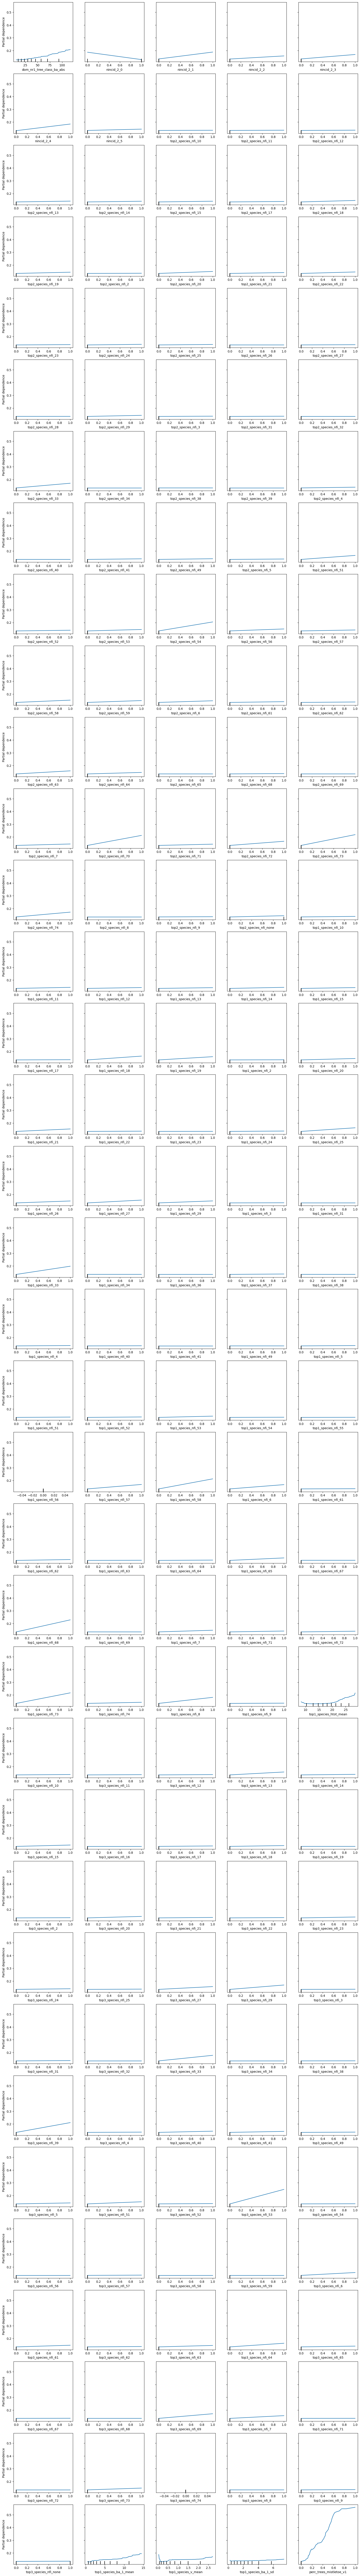

In [514]:
# Create PDP for the top n variables
# Get top n variables
n_pdps = 10
top_vars_pdp_ohed = df_featimp_withagg.head(n_pdps)["Vars_in_key"].to_list()
top_vars_pdp_ohed = [item for sublist in top_vars_pdp_ohed for item in sublist]

fig, axs = plt.subplots(figsize=(20, n_pdps * 15))
my_pdp = PartialDependenceDisplay.from_estimator(
    rf_best,
    X_train_final,
    top_vars_pdp_ohed,
    # sample_weight=get_weights_from_y(y_train_final, user_input["weight_method"]),
    n_cols=5,
    # n_jobs=-1, # Adding this, slows down the process a lot...
    ax=axs,
)

print(f"Top {n_pdps} variables for PDPs (ohe): {top_vars_pdp_ohed}")

In [474]:
# Reduce var_ohe_dict to hold only keys where a value in the key is in top_vars_pdp_ohed
var_ohe_dict_reduced = {
    key: value
    for key, value in var_ohe_dict.items()
    if any(col in top_vars_pdp_ohed for col in value)
}
dict_flipd = {
    ohe: orig for orig, ohe_list in original_to_ohe.items() for ohe in ohe_list
}
dict_flipd

{'dom_nr1_tree_class_ba_abs': 'dom_nr1_tree_class_ba_abs',
 'nincid_2_0': 'nincid_2',
 'nincid_2_1': 'nincid_2',
 'nincid_2_2': 'nincid_2',
 'nincid_2_3': 'nincid_2',
 'nincid_2_4': 'nincid_2',
 'nincid_2_5': 'nincid_2',
 'perc_trees_mistletoe_v1': 'perc_trees_mistletoe_v1',
 'top1_species_ba_1_mean': 'top1_species_ba_1_mean',
 'top1_species_ba_1_sd': 'top1_species_ba_1_sd',
 'top1_species_htot_mean': 'top1_species_htot_mean',
 'top1_species_nfi_10': 'top1_species_nfi',
 'top1_species_nfi_11': 'top1_species_nfi',
 'top1_species_nfi_12': 'top1_species_nfi',
 'top1_species_nfi_13': 'top1_species_nfi',
 'top1_species_nfi_14': 'top1_species_nfi',
 'top1_species_nfi_15': 'top1_species_nfi',
 'top1_species_nfi_17': 'top1_species_nfi',
 'top1_species_nfi_18': 'top1_species_nfi',
 'top1_species_nfi_19': 'top1_species_nfi',
 'top1_species_nfi_2': 'top1_species_nfi',
 'top1_species_nfi_20': 'top1_species_nfi',
 'top1_species_nfi_21': 'top1_species_nfi',
 'top1_species_nfi_22': 'top1_species_nfi'

In [525]:
# Extract data from PDP object
final_df = pd.DataFrame(
    {
        "ohed_var": [],
        "non_ohed_var": [],
        "y_values": [],
        "x_values": [],
    }
)

for i in range(len(top_vars_pdp_ohed)):
    new_row = pd.DataFrame(
        {
            "ohed_var": top_vars_pdp_ohed[i],
            "non_ohed_var": dict_flipd[top_vars_pdp_ohed[i]],
            "y_values": my_pdp.pd_results[i]["average"][0].tolist(),
            "x_values": my_pdp.pd_results[i]["values"][0].tolist(),
        }
    )
    # Append new row to final_df
    final_df = pd.concat([final_df, new_row], axis=0)

/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


dom_nr1_tree_class_ba_abs
1


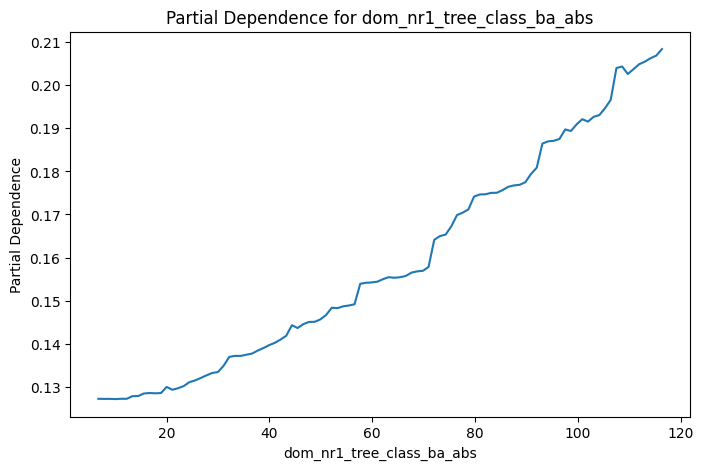

nincid_2
6


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/261404640.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


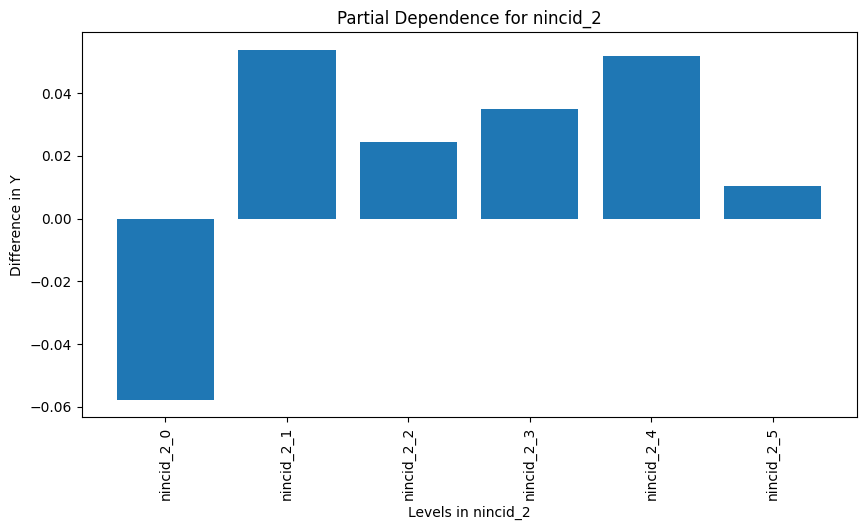

perc_trees_mistletoe_v1
1


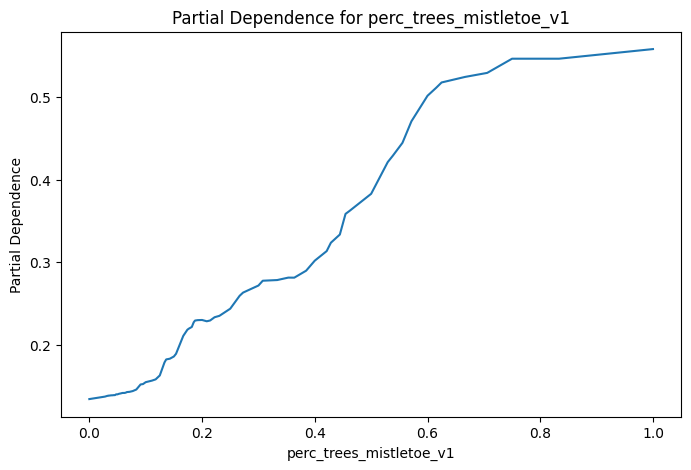

top1_species_ba_1_mean
1


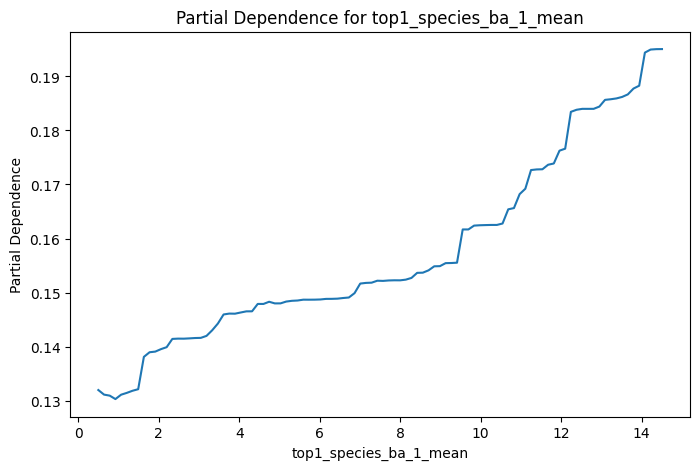

top1_species_ba_1_sd
1


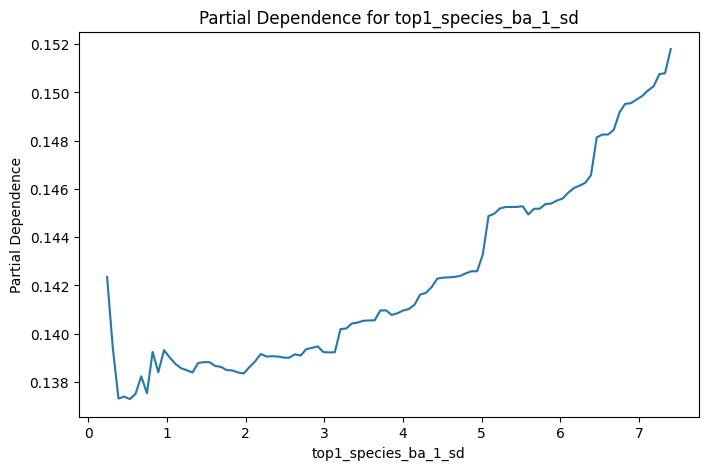

top1_species_htot_mean
1


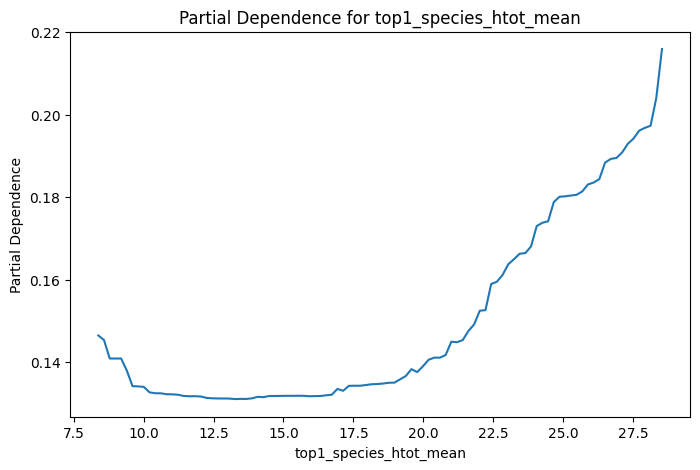

top1_species_nfi
55


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/261404640.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


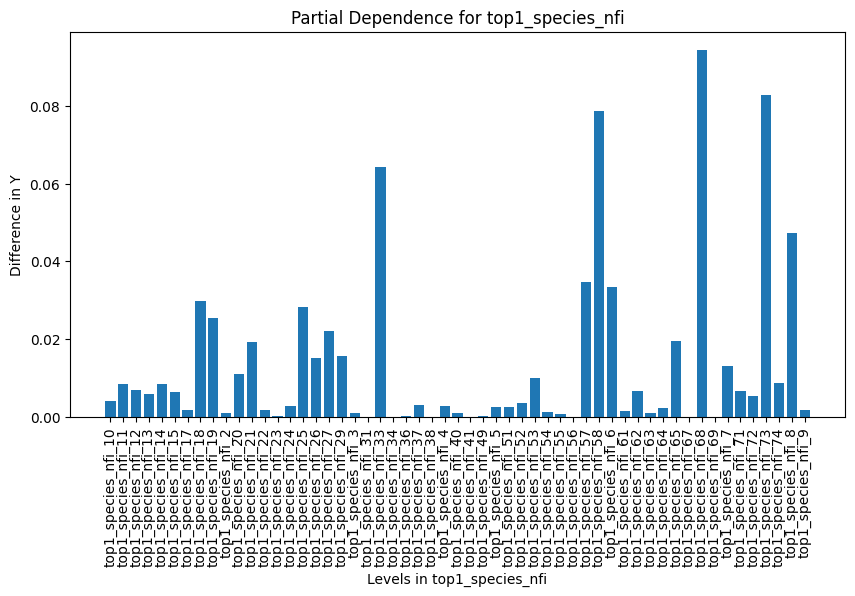

top1_species_v_mean
1


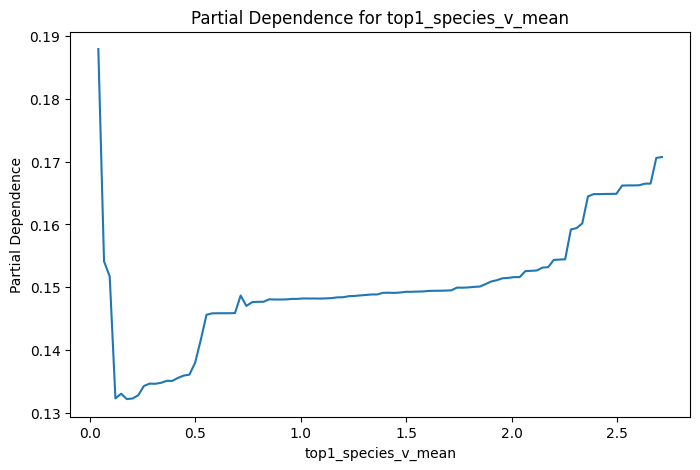

top2_species_nfi
57


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/261404640.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


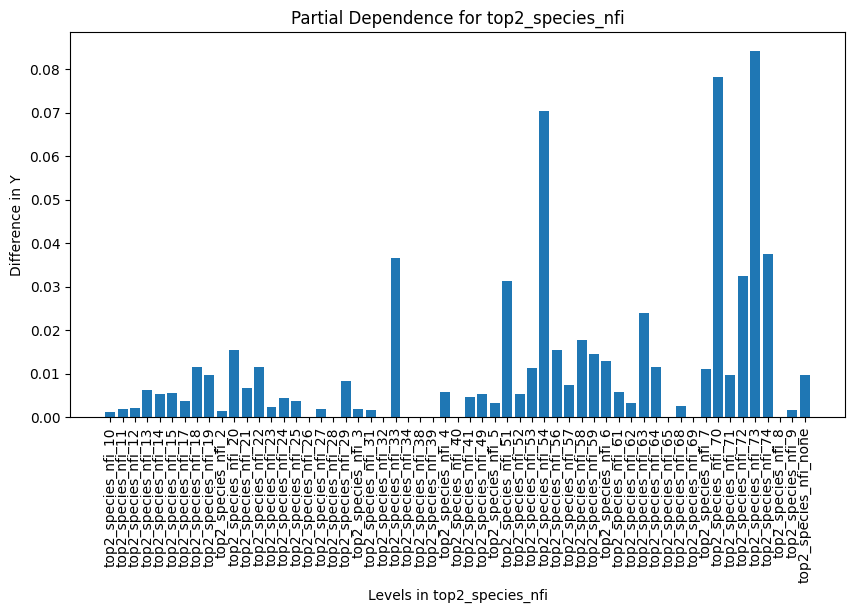

top3_species_nfi
56


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/261404640.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(), rotation=90)


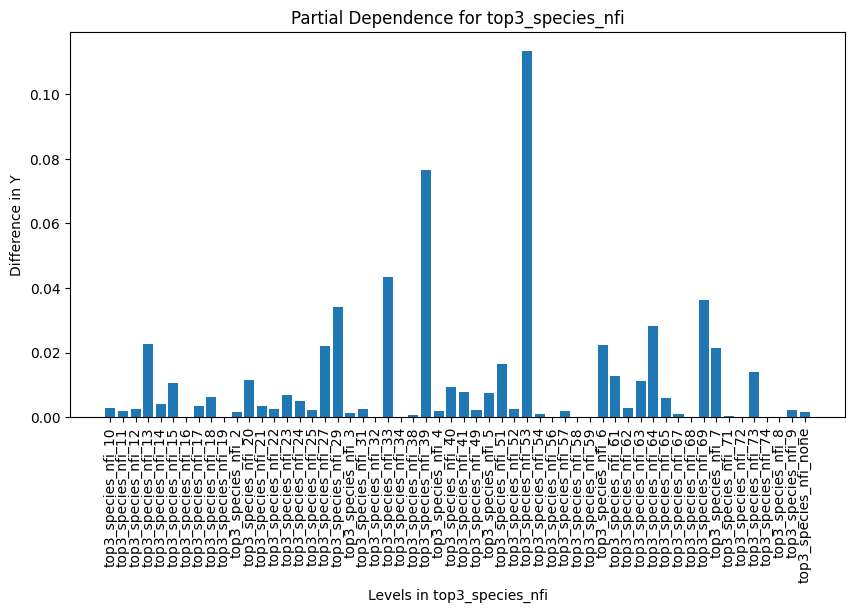

In [577]:
# Make groups based on the non-ohed variable
# Todo: Needs improvement for ordinal ohe'd variables to show as lines and not as bars
df_groups = final_df.groupby("non_ohed_var")

for name, group in df_groups:
    # print(name)
    # print(len(reduced_var_ohe_dict[name]))
    if len(reduced_var_ohe_dict[name]) > 1:
        # Make barplot
        make_pdp_subplots(df_in=group, var_name=name, var_type="categorical")
    else:
        # Make lineplot
        make_pdp_subplots(df_in=group, var_name=name, var_type="numerical")

In [576]:
def make_pdp_subplots(ax=None, df_in=None, var_name=None, var_type=None):
    # If variable is categorical
    if var_type == "categorical":
        df = df_in[df_in["non_ohed_var"] == var_name].copy()

        # Pivot the table to get differences
        pivot_df = df.pivot(index="ohed_var", columns="x_values", values="y_values")
        pivot_df["difference"] = pivot_df[1] - pivot_df[0]

        # Plot
        fig, axs = plt.subplots(figsize=(10, 5))
        axs.bar(pivot_df.index, pivot_df["difference"])
        axs.set_xlabel(f"Levels in {var_name}")
        axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
        axs.set_ylabel("Difference in Y")
        axs.set_title(f"Partial Dependence for {var_name}")
        plt.show()

    else:
        # If variable is ordinal or numerical, make a line plot
        df_tmp = df_in[df_in["non_ohed_var"] == var_name].copy()
        df_tmp["x_values"] = df_tmp["x_values"].astype(float)

        # Plot
        fig, axs = plt.subplots(figsize=(8, 5))
        axs.plot(df_tmp["x_values"], df_tmp["y_values"])
        axs.set_xlabel(var_name)
        axs.set_ylabel("Partial Dependence")
        axs.set_title(f"Partial Dependence for {var_name}")
        plt.show()

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/3897208612.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/3897208612.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/3897208612.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_31873/3897208612.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)


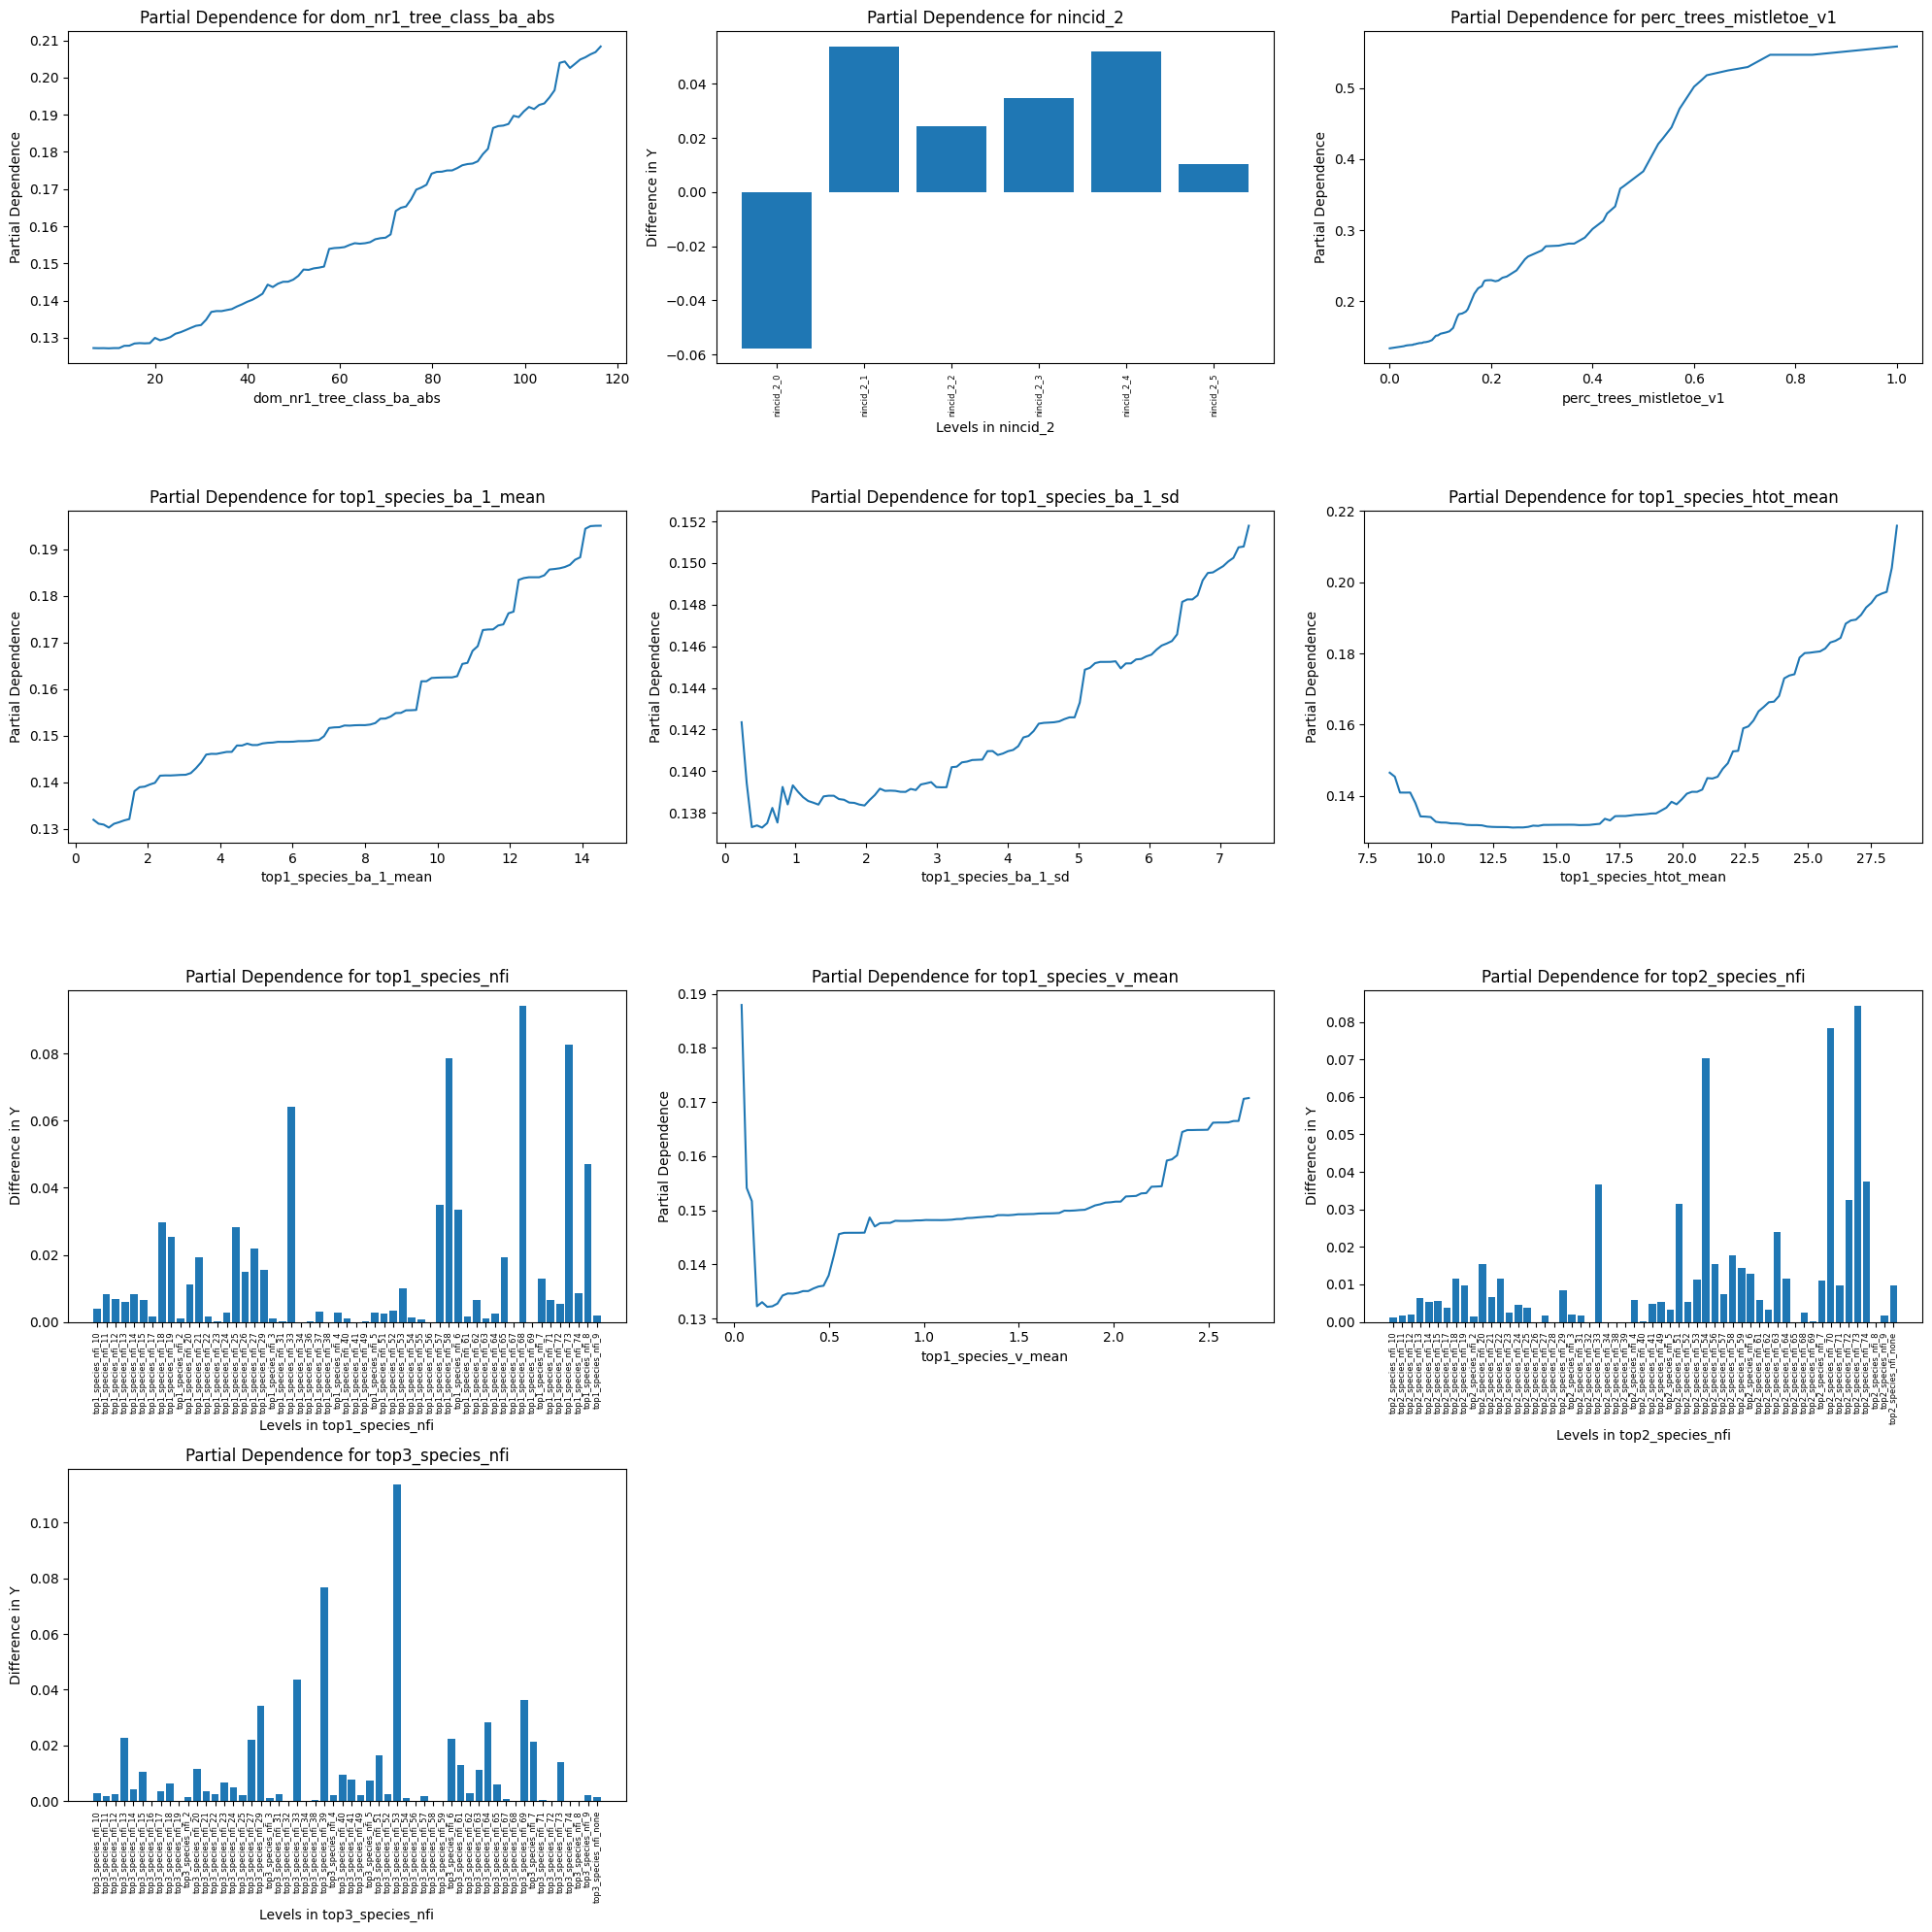

In [597]:
import matplotlib.pyplot as plt


def make_pdp_subplots(ax, df_in, var_name, var_type):
    if var_type == "categorical":
        df = df_in[df_in["non_ohed_var"] == var_name].copy()
        pivot_df = df.pivot(index="ohed_var", columns="x_values", values="y_values")
        pivot_df["difference"] = pivot_df[1] - pivot_df[0]

        # Plot on the provided axis
        ax.bar(pivot_df.index, pivot_df["difference"])
        ax.set_xlabel(f"Levels in {var_name}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
        ax.set_ylabel("Difference in Y")
        ax.set_title(f"Partial Dependence for {var_name}")

    else:
        df_tmp = df_in[df_in["non_ohed_var"] == var_name].copy()
        df_tmp["x_values"] = df_tmp["x_values"].astype(float)

        # Plot on the provided axis
        ax.plot(df_tmp["x_values"], df_tmp["y_values"])
        ax.set_xlabel(var_name)
        ax.set_ylabel("Partial Dependence")
        ax.set_title(f"Partial Dependence for {var_name}")


# Create a figure with m rows x n columns of subplots
fig, axs = plt.subplots(4, 3, figsize=(20, 20))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array to easily iterate over it

# Iterate over groups and plot
ax_idx = 0
for name, group in df_groups:
    if len(reduced_var_ohe_dict[name]) > 1:
        # Make barplot
        make_pdp_subplots(
            ax=axs[ax_idx], df_in=group, var_name=name, var_type="categorical"
        )
    else:
        # Make lineplot
        make_pdp_subplots(
            ax=axs[ax_idx], df_in=group, var_name=name, var_type="numerical"
        )
    ax_idx += 1
    if ax_idx == 10:  # Stop plotting after 10 plots
        break

# Turn off the last two axes
for ax in axs[10:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

***

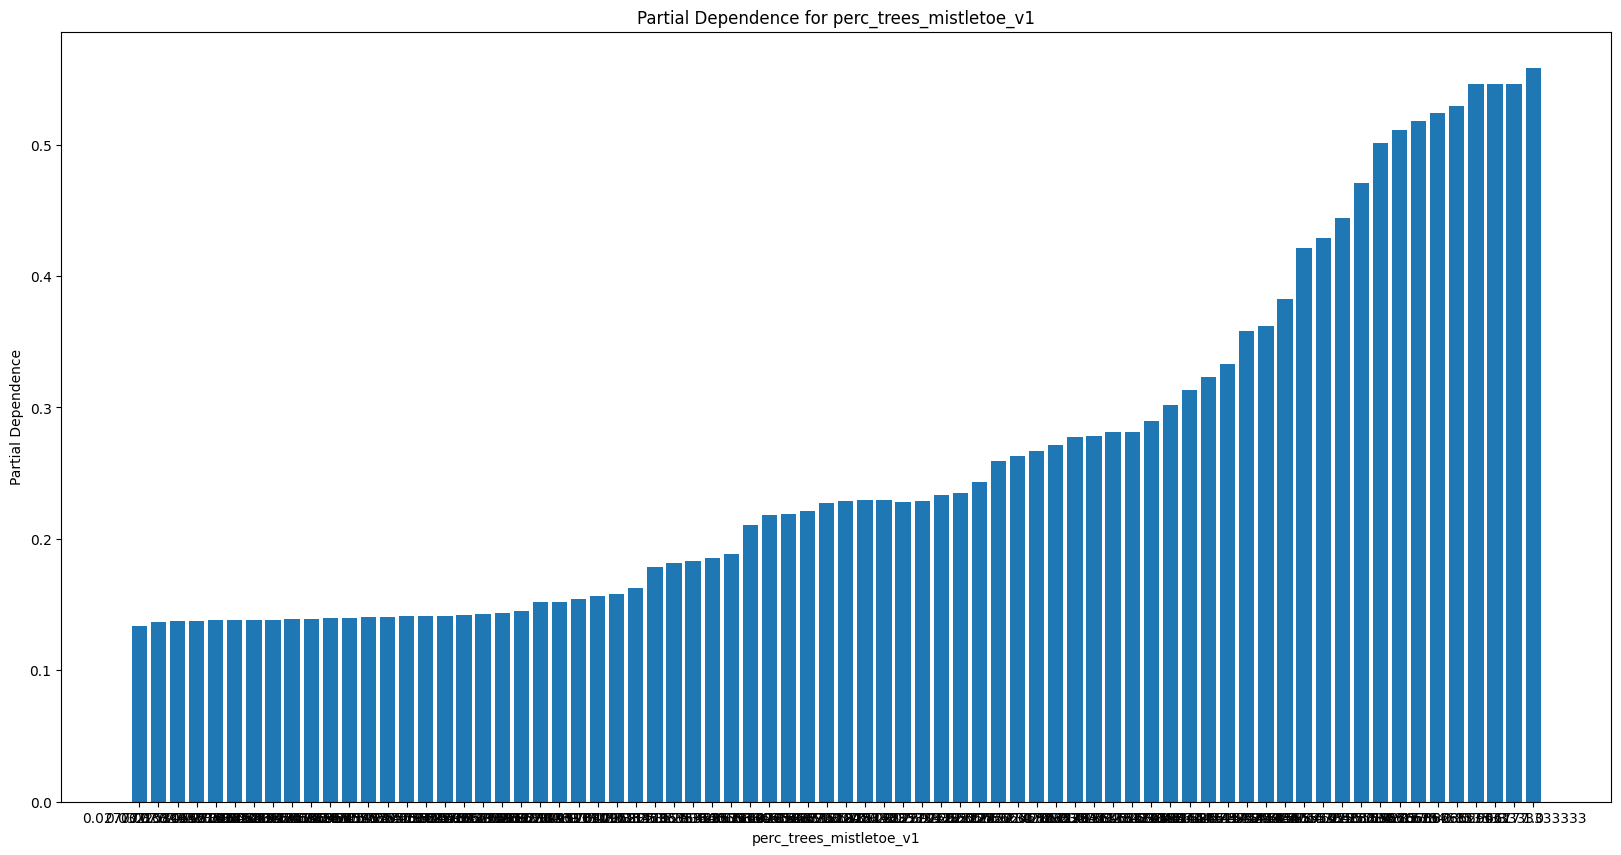

,ohed_var,non_ohed_var,y_values,x_values
0,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.133840,0.0
1,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.136851,0.0277777777777778
2,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.137807,0.032258064516129
3,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.137807,0.0333333333333333
4,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.138086,0.0344827586206897
...,...,...,...,...
69,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.529342,0.705882352941177
70,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.546547,0.75
71,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.546548,0.8
72,perc_trees_mistletoe_v1,perc_trees_mistletoe_v1,0.546548,0.833333333333333


In [543]:
make_plot_for_cat_var(final_df, "perc_trees_mistletoe_v1")

In [531]:
final_df.value_counts("non_ohed_var")

non_ohed_var
top2_species_nfi             114
top3_species_nfi             111
top1_species_nfi             109
dom_nr1_tree_class_ba_abs    100
top1_species_ba_1_mean       100
top1_species_ba_1_sd         100
top1_species_htot_mean       100
top1_species_v_mean          100
perc_trees_mistletoe_v1       74
nincid_2                      12
Name: count, dtype: int64

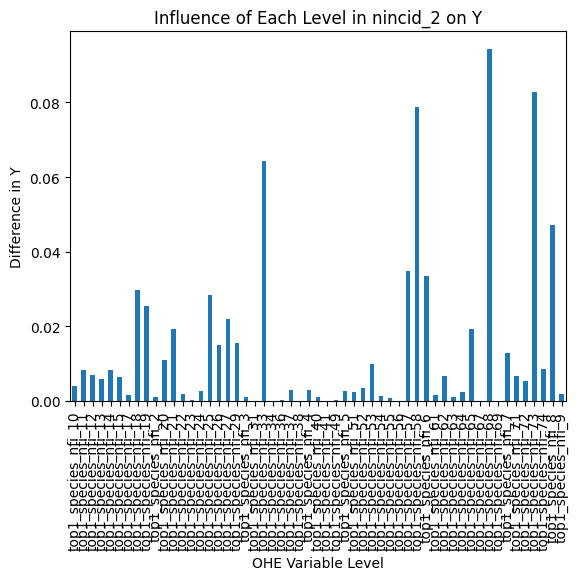

In [532]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (replace this with your actual DataFrame)
data = final_df.query("non_ohed_var == 'top1_species_nfi'")

df = pd.DataFrame(data)

# Pivot the table to get differences
pivot_df = df.pivot(index="ohed_var", columns="x_values", values="y_values")
pivot_df["difference"] = pivot_df[1] - pivot_df[0]

# Plot
pivot_df["difference"].plot(kind="bar")
plt.xlabel("OHE Variable Level")
plt.ylabel("Difference in Y")
plt.title("Influence of Each Level in nincid_2 on Y")
plt.show()

In [453]:
for feature_result in my_pdp.pd_results:
    print(feature_result["grid_values"])
    break
    print("-----------------------------------")

[array([  6.73181186,   7.83909545,   8.94637903,  10.05366261,
        11.16094619,  12.26822977,  13.37551335,  14.48279693,
        15.59008052,  16.6973641 ,  17.80464768,  18.91193126,
        20.01921484,  21.12649842,  22.233782  ,  23.34106559,
        24.44834917,  25.55563275,  26.66291633,  27.77019991,
        28.87748349,  29.98476708,  31.09205066,  32.19933424,
        33.30661782,  34.4139014 ,  35.52118498,  36.62846856,
        37.73575215,  38.84303573,  39.95031931,  41.05760289,
        42.16488647,  43.27217005,  44.37945363,  45.48673722,
        46.5940208 ,  47.70130438,  48.80858796,  49.91587154,
        51.02315512,  52.1304387 ,  53.23772229,  54.34500587,
        55.45228945,  56.55957303,  57.66685661,  58.77414019,
        59.88142378,  60.98870736,  62.09599094,  63.20327452,
        64.3105581 ,  65.41784168,  66.52512526,  67.63240885,
        68.73969243,  69.84697601,  70.95425959,  72.06154317,
        73.16882675,  74.27611033,  75.38339392,  76.4

In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Your updated mapping structure
original_to_ohe = var_ohe_dict_reduced

# Invert the mapping to get OHE to original mapping
ohe_to_original = {
    ohe: orig for orig, ohe_list in original_to_ohe.items() for ohe in ohe_list
}

# Your pd_results data
pd_results = my_pdp.pd_results

# Convert pd_results to DataFrame
df_list = []
for feature_result in pd_results:
    for i in range(len(feature_result["values"])):
        df = pd.DataFrame(
            {
                # "feature": feature_result["feature"][i],
                "grid_values": feature_result["grid_values"][i],
                "average": feature_result["average"][i],
            }
        )
        df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)
full_df

,grid_values,average
0,6.731812,0.127239
1,7.839095,0.127206
2,8.946379,0.127220
3,10.053663,0.127169
4,11.160946,0.127237
...,...,...
915,0.705882,0.529342
916,0.750000,0.546547
917,0.800000,0.546548
918,0.833333,0.546548


In [ ]:

# Map OHE features to original features
full_df["original_feature"] = full_df["feature"].map(ohe_to_original)

# Aggregate results for original features
aggregated_results = (
    full_df.groupby("original_feature")
    .agg(
        {
            "grid_values": "first",  # Assuming grid values are the same for all OHE features of the same original feature
            "average": "sum",  # Summing the average effects
        }
    )
    .reset_index()
)

# Plot the aggregated results
for _, row in aggregated_results.iterrows():
    plt.figure()
    plt.plot(row["grid_values"], row["average"], label=row["original_feature"])
    plt.xlabel("Grid Values")
    plt.ylabel("Average PD")
    plt.title(f'Partial Dependence of {row["original_feature"]}')
    plt.legend()
    plt.show()

In [417]:
n_pdps = 10
top_vars_pdp = df_featimp_withagg.head(n_pdps)["Vars_in_key"].to_list()
top_vars_pdp = [item for sublist in top_vars_pdp for item in sublist]

top_vars_pdp

['dom_nr1_tree_class_ba_abs',
 'nincid_2_0',
 'nincid_2_1',
 'nincid_2_2',
 'nincid_2_3',
 'nincid_2_4',
 'nincid_2_5',
 'top2_species_nfi_10',
 'top2_species_nfi_11',
 'top2_species_nfi_12',
 'top2_species_nfi_13',
 'top2_species_nfi_14',
 'top2_species_nfi_15',
 'top2_species_nfi_17',
 'top2_species_nfi_18',
 'top2_species_nfi_19',
 'top2_species_nfi_2',
 'top2_species_nfi_20',
 'top2_species_nfi_21',
 'top2_species_nfi_22',
 'top2_species_nfi_23',
 'top2_species_nfi_24',
 'top2_species_nfi_25',
 'top2_species_nfi_26',
 'top2_species_nfi_27',
 'top2_species_nfi_28',
 'top2_species_nfi_29',
 'top2_species_nfi_3',
 'top2_species_nfi_31',
 'top2_species_nfi_32',
 'top2_species_nfi_33',
 'top2_species_nfi_34',
 'top2_species_nfi_38',
 'top2_species_nfi_39',
 'top2_species_nfi_4',
 'top2_species_nfi_40',
 'top2_species_nfi_41',
 'top2_species_nfi_49',
 'top2_species_nfi_5',
 'top2_species_nfi_51',
 'top2_species_nfi_52',
 'top2_species_nfi_53',
 'top2_species_nfi_54',
 'top2_species_nfi_5

In [407]:
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import numpy as np

# Assume 'model' is your trained model and 'X' is your data with one-hot-encoded variables
X = X_train_final
model = rf_best


# Names of one-hot-encoded features for the categorical variable of interest
# feature_names = [
#     "category_level_1",
#     "category_level_2",
#     "category_level_3",
#     ...,
# ]  # Adjust as necessary
encoded_features = [list(X.columns).index(feat) for feat in feature_names]

# Compute the partial dependence for each one-hot-encoded feature
fig, axs = plt.subplots(len(encoded_features), figsize=(10, len(encoded_features) * 3))
for i, feature in enumerate(encoded_features):
    display = plot_partial_dependence(model, X, features=[feature], ax=axs[i])
axs[0].set_title("Partial Dependence of each level")

# To compute the average effect, you need to extract the 'average' attribute from the display
# object and then compute the average across all levels
# Note: This step assumes that all categorical features have the same number of points on the x-axis
# which should be the case for one-hot-encoded features representing the same original feature

# The averaged partial dependence values
avg_pdp = np.mean([ax.lines[0].get_ydata() for ax in axs], axis=0)

# Plotting the average partial dependence
plt.figure(figsize=(8, 5))
plt.plot(display.deciles[0], avg_pdp, label="Average Partial Dependence")
plt.xlabel("Feature value")
plt.ylabel("Partial dependence")
plt.title("Average Partial Dependence of Categorical Variable")
plt.legend()
plt.show()

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/Users/pascal/repos/padasch/ifn_analysis/ifna-venv/lib/python3.10/site-packages/sklearn/inspection/__init__.py)

## Save Model

In [ ]:
import pickle

# Pickle model
with open(f"{current_dir}/final_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)

# Pickle test data
with open(f"{current_dir}/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open(f"{current_dir}/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)